# Simple Row-Aggregating Features With Stacking In The Movielens Dataset 

This example illustrates using `pandas`-munging capabilities in estimators building features that draw from several rows. We will use a single table from the [Movielens dataset](https://grouplens.org/datasets/movielens/) (F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS)).

## Loading The Data

In this example, we'll only use the dataset table describing the ratings themselves. I.e., each row is an instance of a single rating given by a specific user to a specific movie.

In [1]:
import os

from sklearn import base
from scipy import stats
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
sns.despine()

import ibex
from ibex.sklearn import model_selection as pd_model_selection
from ibex.sklearn import linear_model as pd_linear_model
from ibex.xgboost import XGBRegressor as PdXGBRegressor

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
ratings = pd.read_csv(
    '../movielens_data/ml-100k/u.data', 
    sep='\t', 
    header=None, 
    names=['user_id', 'item_id', 'rating', 'timestamp'])
features = ['user_id', 'item_id']
ratings = ratings.sample(frac=1)
ratings[features + ['rating']].head()

,user_id,item_id,rating
60960,389,1007,4
90922,189,185,5
73636,23,154,3
11805,276,168,5
38484,403,597,2


## dd 

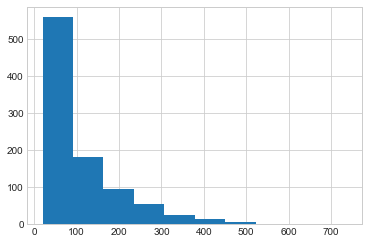

In [3]:
hist(ratings.user_id.groupby(ratings.user_id).count().values);

In [4]:
def sample_group(g):
    p, max_ = 0.5, 200
    num = stats.binom.rvs(min(len(g), max_), p, size=1)[0]
    frac = float(num) / len(g)
    return g.sample(frac=frac)


reduced_ratings = ratings.groupby(ratings.user_id, as_index=False).apply(sample_group)
reduced_ratings.index = reduced_ratings.index.levels[1]
reduced_ratings = reduced_ratings.sample(frac=1)
reduced_ratings.head()

,user_id,item_id,rating,timestamp
51336,460,532,3,882912370
23021,224,243,2,888082277
46540,421,915,4,892241252
39662,360,175,3,880355888
1118,7,549,4,891353086


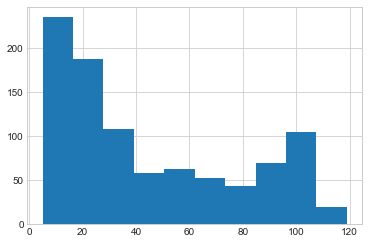

In [5]:
hist(reduced_ratings.user_id.groupby(reduced_ratings.user_id).count().values);

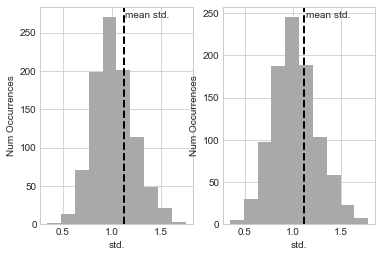

In [6]:
subplot(1, 2, 1)
by_user_std = ratings.rating.groupby(ratings.user_id).std()
axvline(
    ratings.rating.std(), 
    linewidth=2,
    linestyle='dashed',
    color='black');
annotate(
    'mean std.',
    xy=(1.01 * ratings.rating.std(), int(max(hist(by_user_std)[0]))));
hist(
    by_user_std,
    color='darkgrey');
xlabel('std.')
ylabel('Num Occurrences')

subplot(1, 2, 2)
by_user_std = reduced_ratings.rating.groupby(reduced_ratings.user_id).std()
axvline(
    reduced_ratings.rating.std(), 
    linewidth=2,
    linestyle='dashed',
    color='black');
annotate(
    'mean std.',
    xy=(1.01 * reduced_ratings.rating.std(), int(max(hist(by_user_std)[0]))));
hist(
    by_user_std,
    color='darkgrey');
xlabel('std.')
ylabel('Num Occurrences')

## Stacking Using Pandas

Unsuprisingly, the results are even worse than before. Methodically, this is the correct way of building the feature without peeking, and so the CV result should intuitively be weaker.

In [65]:
(user_ratings.rating.sum() - user_ratings.rating) / float(len(user_ratings) - 1)

61085    3.529885
8435     3.529875
37107    3.529865
523      3.529855
84678    3.529845
94144    3.529855
78939    3.529845
82467    3.529855
39472    3.529875
5434     3.529865
59673    3.529865
59967    3.529865
5135     3.529865
13732    3.529865
86476    3.529875
96526    3.529845
86937    3.529865
93112    3.529875
99039    3.529865
25722    3.529855
6978     3.529845
69709    3.529855
18089    3.529875
88760    3.529855
50527    3.529865
91486    3.529875
89581    3.529875
50229    3.529865
4875     3.529885
85890    3.529855
           ...   
67515    3.529855
45942    3.529845
10851    3.529865
8610     3.529855
79193    3.529855
1019     3.529845
69971    3.529875
45334    3.529845
21443    3.529855
906      3.529855
4436     3.529865
94301    3.529845
94167    3.529845
21174    3.529845
64073    3.529845
82150    3.529885
33393    3.529885
45419    3.529875
60898    3.529875
56565    3.529875
45581    3.529865
52579    3.529855
15361    3.529855
18468    3.529865
40367    3

user_rating_stats = \
    ratings.rating.groupby(ratings.user_id).agg({'user_id_sum': np.sum, 'user_id_count': 'count'})
user_rating_stats.head()

In [19]:
user_ratings = pd.merge(
    ratings[['user_id', 'rating']],
    user_rating_stats,
    left_on='user_id',
    right_index=True,
    how='left')
user_ratings.head()

,user_id,rating,user_id_sum,user_id_count
61085,653,1,762,283
8435,201,2,1170,386
37107,627,3,596,181
523,224,4,422,141
84678,927,5,443,120


In [20]:
user_ratings[user_ratings.user_id == 1]

,user_id,rating,user_id_sum,user_id_count
3358,1,4,982,272
34550,1,5,982,272
43280,1,4,982,272
53552,1,5,982,272
1617,1,4,982,272
87967,1,5,982,272
478,1,4,982,272
11859,1,3,982,272
56312,1,5,982,272
55636,1,1,982,272


In [21]:
user_ratings.user_id_count -= 1
user_ratings['user_id_mean'] = np.where(
    user_ratings.user_id_count == 0,
    -1,
    (user_ratings.user_id_sum - user_ratings.rating) / user_ratings.user_id_count)

In [22]:
user_ratings.head()

,user_id,rating,user_id_sum,user_id_count,user_id_mean
61085,653,1,762,282,2.698582
8435,201,2,1170,385,3.033766
37107,627,3,596,180,3.294444
523,224,4,422,140,2.985714
84678,927,5,443,119,3.680672


In [23]:
user_ratings[user_ratings.user_id == 1]

,user_id,rating,user_id_sum,user_id_count,user_id_mean
3358,1,4,982,271,3.608856
34550,1,5,982,271,3.605166
43280,1,4,982,271,3.608856
53552,1,5,982,271,3.605166
1617,1,4,982,271,3.608856
87967,1,5,982,271,3.605166
478,1,4,982,271,3.608856
11859,1,3,982,271,3.612546
56312,1,5,982,271,3.605166
55636,1,1,982,271,3.619926


## Building A Pandas-Munging Stacking Estimator

We'll now use Pandas to build a feature building these features. 

* For each movie, we'll store the mean score & number of occurrences.

* For each user, we'll store the mean score & number of occurrences.

In [7]:
class ScoresAggregator(base.BaseEstimator, base.TransformerMixin, ibex.FrameMixin):
    def fit(self, X, y):
        self._mean = y.mean()
        self._user_id_stats = y.groupby(X.user_id).agg({'user_id_mean': np.mean, 'user_id_count': 'count'})
        return self
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        
        user_rating_stats = \
            y.groupby(X.user_id).agg({'user_id_sum': np.sum, 'user_id_count': 'count'})        
        X = pd.concat([X['user_id'], y], axis=1)
        X.columns = ['user_id', 'rating']
        user_ratings = pd.merge(
            X,
            user_rating_stats,
            left_on='user_id',
            right_index=True,
            how='left')
        user_ratings.user_id_count -= 1
        user_ratings['user_id_mean'] = np.where(
            user_ratings.user_id_count == 0,
            -1,
            (user_ratings.user_id_sum - user_ratings.rating) / user_ratings.user_id_count)
        
        return user_ratings[['user_id_mean', 'user_id_count']]
        
    def transform(self, X):
        user_ratings = pd.merge(
            X[['user_id']],
            self._user_id_stats,
            left_on='user_id',
            right_index=True,
            how='left')[['user_id_mean', 'user_id_count']]
        user_ratings.user_id_mean = user_ratings.user_id_mean.fillna(self._mean)
        user_ratings.user_id_count = user_ratings.user_id_count.fillna(0)
        return user_ratings

In [21]:
f = ScoresAggregator()

In [22]:
f.fit_transform(ratings[features], ratings.rating)

,user_id_mean,user_id_count
64953,3.268750,160
24115,3.462222,225
40336,3.612903,155
12643,3.123173,479
43824,3.169811,159
40654,3.533724,341
68405,3.362319,483
64528,2.907895,684
27471,3.834197,193
7001,3.725490,153


In [ ]:
prd = ScoresAggregator() | PdXGBRegressor()
hist(
    pd_model_selection.cross_val_score(prd, ratings[features], ratings.rating, cv=20, n_jobs=-1),
    color='darkgrey');
xlabel('CV Score')
ylabel('Num Occurrences')
figtext(
    0, 
    -0.1, 
    'Histogram of cross-validated scores');

The CV histogram indicates that the results are now positive.

In [20]:
prd.fit(ratings[features], ratings.rating).score(ratings[features], ratings.rating)

[[ 1.          0.99949012]
 [ 0.99949012  1.        ]]


-0.29483564792718364

In [22]:
plot(
    ratings.rating,
    prd.fit(ratings[features], ratings.rating).predict(ratings[features]),
    '+');

[[ 1.          0.99949012]
 [ 0.99949012  1.        ]]


In [8]:
class ScoresAggregator(base.BaseEstimator, base.TransformerMixin, ibex.FrameMixin):
    def fit(self, X, y):
        self._mean = y.mean()
        self._user_id_stats = y.groupby(X.user_id).agg({'user_id_mean': np.mean, 'user_id_count': 'count'})
        
        return self
        
    def transform(self, X):
        user_ratings = pd.merge(
            X[['user_id']],
            self._user_id_stats,
            left_on='user_id',
            right_index=True,
            how='left')[['user_id_mean', 'user_id_count']]
        user_ratings.user_id_mean = user_ratings.user_id_mean.fillna(self._mean)
        user_ratings.user_id_count = user_ratings.user_id_count.fillna(0)
        return user_ratings

In [51]:
class StackingScoresAggregator(base.BaseEstimator, base.TransformerMixin, ibex.FrameMixin):
    def fit(self, X, y):
        self.x_columns = X
        self._mean = y.mean()
        self._user_id_stats = y.groupby(X.user_id).agg({'user_id_mean': np.mean, 'user_id_count': 'count'})
        return self
    
    def fit_transform(self, X, y):
        user_rating_stats = \
            y.groupby(X.user_id).agg({'user_id_sum': np.sum, 'user_id_count': 'count'})        
        X_ = pd.concat([X['user_id'], y], axis=1)
        X_.columns = ['user_id', 'rating']
        user_ratings = pd.merge(
            X_,
            user_rating_stats,
            left_on='user_id',
            right_index=True,
            how='left')
        user_ratings.user_id_count -= 1
        user_ratings['user_id_mean'] = np.where(
            user_ratings.user_id_count == 0,
            y.mean(), # Tmp Ami
            (user_ratings.user_id_sum - user_ratings.rating) / user_ratings.user_id_count)
        
        print(
            np.corrcoef(user_ratings.user_id_mean, self.fit(X, y).transform(X).user_id_mean))
        
        self.fit(X, y)
        
        # return self.fit(X, y).transform(X)
        print(user_ratings.columns)
        return user_ratings[['user_id_mean', 'user_id_count']]
        
    def transform(self, X):
        user_ratings = pd.merge(
            X[['user_id']],
            self._user_id_stats,
            left_on='user_id',
            right_index=True,
            how='left')[['user_id_mean', 'user_id_count']]
        user_ratings.user_id_mean = user_ratings.user_id_mean.fillna(self._mean)
        user_ratings.user_id_count = user_ratings.user_id_count.fillna(0)
        return user_ratings
    
from ibex.sklearn.linear_model import LinearRegression as PDLinearRegression
prd = ScoresAggregator() | PDLinearRegression()
stacking_prd = StackingScoresAggregator() | PDLinearRegression()
stacking_prd.fit(reduced_ratings[features], reduced_ratings.rating).score(ratings[features], ratings.rating)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


[[ 1.          0.99723912]
 [ 0.99723912  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


0.15120876214160572

In [52]:
scores = pd_model_selection.cross_val_score(prd, reduced_ratings[features], reduced_ratings.rating, cv=2000, n_jobs=-1)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will b

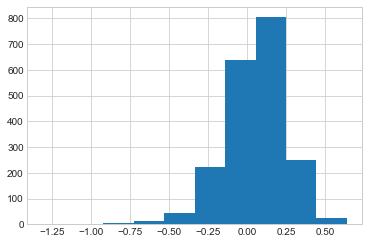

In [41]:
hist(scores);

In [53]:
stacking_scores = pd_model_selection.cross_val_score(stacking_prd, reduced_ratings[features], reduced_ratings.rating, cv=2000, n_jobs=-1)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-p

[[ 1.          0.99723262]
 [ 0.99723262  1.        ]]
[[ 1.          0.99723641]
 [ 0.99723641  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723387]
 [ 0.99723387  1.        ]][[ 1.          0.99723608]
 [ 0.99723608  1.        ]][[ 1.         0.9972369]
 [ 0.9972369  1.       ]]
[[ 1.          0.99723756]
 [ 0.99723756  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723148]
 [ 0.99723148  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723532]
 [ 0.99723532  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99724029]
 [ 0.99724029  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723804]
 [ 0.99723804  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723554]
 [ 0.99723554  1.        ]][[ 1.          0.99723549]
 [ 0.99723549  1.        ]][[ 1.          0.99723898]
 [ 0.99723898  1.        ]]


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723808]
 [ 0.99723808  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723249]
 [ 0.99723249  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723861]
 [ 0.99723861  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723828]
 [ 0.99723828  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723887]
 [ 0.99723887  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723846]
 [ 0.99723846  1.        ]][[ 1.          0.99723317]
 [ 0.99723317  1.        ]][[ 1.         0.9972347]
 [ 0.9972347  1.       ]]


[[ 1.          0.99723523]
 [ 0.99723523  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723408]
 [ 0.99723408  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972353]
 [ 0.9972353  1.       ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723531]
 [ 0.99723531  1.        ]][[ 1.          0.99723557]
 [ 0.99723557  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723475]
 [ 0.99723475  1.        ]][[ 1.          0.99723412]
 [ 0.99723412  1.        ]][[ 1.          0.99723465]
 [ 0.99723465  1.        ]]


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723658]
 [ 0.99723658  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723333]
 [ 0.99723333  1.        ]][[ 1.         0.9972367]
 [ 0.9972367  1.       ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723688]
 [ 0.99723688  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723715]
 [ 0.99723715  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723748]
 [ 0.99723748  1.        ]][[ 1.          0.99722174]
 [ 0.99722174  1.        ]]
[[ 1.          0.99723544]
 [ 0.99723544  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723267]
 [ 0.99723267  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723049]
 [ 0.99723049  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723692]
 [ 0.99723692  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/loc

[[ 1.          0.99723517]
 [ 0.99723517  1.        ]][[ 1.          0.99723834]
 [ 0.99723834  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723382]
 [ 0.99723382  1.        ]][[ 1.          0.99723547]
 [ 0.99723547  1.        ]]
[[ 1.          0.99723672]
 [ 0.99723672  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723626]
 [ 0.99723626  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.         0.9972397]
 [ 0.9972397  1.       ]][[ 1.          0.99724035]
 [ 0.99724035  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723536]
 [ 0.99723536  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99723845]
 [ 0.99723845  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723695]
 [ 0.99723695  1.        ]]
[[ 1.          0.99723709]
 [ 0.99723709  1.        ]][[ 1.          0.99723777]
 [ 0.99723777  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723343]
 [ 0.99723343  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723167]
 [ 0.99723167  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723187]
 [ 0.99723187  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723601]
 [ 0.99723601  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723554]
 [ 0.99723554  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723654]
 [ 0.99723654  1.        ]]
[[ 1.          0.99723999]
 [ 0.99723999  1.        ]][[ 1.          0.99723782]
 [ 0.99723782  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723446]
 [ 0.99723446  1.        ]]
[[ 1.          0.99723679]
 [ 0.99723679  1.        ]][[ 1.          0.99723689]
 [ 0.99723689  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723376]
 [ 0.99723376  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723784]
 [ 0.99723784  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723114]
 [ 0.99723114  1.        ]][[ 1.          0.99723425]
 [ 0.99723425  1.        ]][[ 1.          0.99723324]
 [ 0.99723324  1.        ]]


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723787]
 [ 0.99723787  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723866]
 [ 0.99723866  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972362]
 [ 0.9972362  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.          0.99723691]
 [ 0.99723691  1.        ]][[ 1.          0.99723334]
 [ 0.99723334  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723499]
 [ 0.99723499  1.        ]][[ 1.          0.99723285]
 [ 0.99723285  1.        ]]
[[ 1.          0.99723522]
 [ 0.99723522  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723795]
 [ 0.99723795  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723899]
 [ 0.99723899  1.        ]][[ 1.          0.99723127]
 [ 0.99723127  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723771]
 [ 0.99723771  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723957]
 [ 0.99723957  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723351]
 [ 0.99723351  1.        ]][[ 1.          0.99723735]
 [ 0.99723735  1.        ]][[ 1.          0.99723585]
 [ 0.99723585  1.        ]]


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723805]
 [ 0.99723805  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723391]
 [ 0.99723391  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


[[ 1.          0.99723533]
 [ 0.99723533  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723531]
 [ 0.99723531  1.        ]][[ 1.          0.99723736]
 [ 0.99723736  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723616]
 [ 0.99723616  1.        ]][[ 1.          0.99723919]
 [ 0.99723919  1.        ]]
[[ 1.          0.99723864]
 [ 0.99723864  1.        ]][[ 1.          0.99723319]
 [ 0.99723319  1.        ]]


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723659]
 [ 0.99723659  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723169]
 [ 0.99723169  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723614]
 [ 0.99723614  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723578]
 [ 0.99723578  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723555]
 [ 0.99723555  1.        ]][[ 1.          0.99723513]
 [ 0.99723513  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.         0.9972384]
 [ 0.9972384  1.       ]][[ 1.          0.99723778]
 [ 0.99723778  1.        ]]
[[ 1.          0.99723632]
 [ 0.99723632  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723662]
 [ 0.99723662  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723812]
 [ 0.99723812  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723677]
 [ 0.99723677  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723705]
 [ 0.99723705  1.        ]][[ 1.          0.99723617]
 [ 0.99723617  1.        ]]
[[ 1.          0.99723379]
 [ 0.99723379  1.        ]]
[[ 1.         0.9972364]
 [ 0.9972364  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723439]
 [ 0.99723439  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723789]
 [ 0.99723789  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972341]
 [ 0.9972341  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723418]
 [ 0.99723418  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723776]
 [ 0.99723776  1.        ]][[ 1.          0.99723686]
 [ 0.99723686  1.        ]][[ 1.          0.99723548]
 [ 0.99723548  1.        ]][[ 1.         0.9972342]
 [ 0.9972342  1.       ]]
[[ 1.          0.99723514]
 [ 0.99723514  1.        ]]


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723389]
 [ 0.99723389  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723671]
 [ 0.99723671  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723379]
 [ 0.99723379  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723325]
 [ 0.99723325  1.        ]][[ 1.          0.99723743]
 [ 0.99723743  1.        ]]

[[ 1.          0.99723367]
 [ 0.99723367  1.        ]][[ 1.          0.99724082]
 [ 0.99724082  1.        ]]
[[ 1.          0.99723633]
 [ 0.99723633  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99722929]
 [ 0.99722929  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723794]
 [ 0.99723794  1.        ]][[ 1.          0.99723714]
 [ 0.99723714  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Ser

[[ 1.          0.99723798]
 [ 0.99723798  1.        ]][[ 1.          0.99724256]
 [ 0.99724256  1.        ]][[ 1.          0.99723789]
 [ 0.99723789  1.        ]][[ 1.          0.99723464]
 [ 0.99723464  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':





[[ 1.          0.99723617]
 [ 0.99723617  1.        ]][[ 1.          0.99723566]
 [ 0.99723566  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723926]
 [ 0.99723926  1.        ]]
[[ 1.          0.99723715]
 [ 0.99723715  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-p

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723575]
 [ 0.99723575  1.        ]][[ 1.          0.99723759]
 [ 0.99723759  1.        ]]
[[ 1.          0.99723622]
 [ 0.99723622  1.        ]][[ 1.          0.99723433]
 [ 0.99723433  1.        ]]
[[ 1.          0.99723664]
 [ 0.99723664  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723571]
 [ 0.99723571  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723661]
 [ 0.99723661  1.        ]][[ 1.          0.99723764]
 [ 0.99723764  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-p

[[ 1.          0.99723282]
 [ 0.99723282  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723405]
 [ 0.99723405  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.         0.9972384]
 [ 0.9972384  1.       ]][[ 1.          0.99723292]
 [ 0.99723292  1.        ]]

[[ 1.         0.9972326]
 [ 0.9972326  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723467]
 [ 0.99723467  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723565]
 [ 0.99723565  1.        ]][[ 1.          0.99723767]
 [ 0.99723767  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-p

[[ 1.          0.99723542]
 [ 0.99723542  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99724022]
 [ 0.99724022  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99723759]
 [ 0.99723759  1.        ]][[ 1.          0.99723683]
 [ 0.99723683  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723245]
 [ 0.99723245  1.        ]]
[[ 1.          0.99723575]
 [ 0.99723575  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723563]
 [ 0.99723563  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723786]
 [ 0.99723786  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/loc

[[ 1.          0.99723769]
 [ 0.99723769  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723548]
 [ 0.99723548  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99723571]
 [ 0.99723571  1.        ]][[ 1.          0.99724046]
 [ 0.99724046  1.        ]]
[[ 1.          0.99723682]
 [ 0.99723682  1.        ]][[ 1.          0.99723903]
 [ 0.99723903  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723683]
 [ 0.99723683  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723974]
 [ 0.99723974  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-p

[[ 1.          0.99723126]
 [ 0.99723126  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723726]
 [ 0.99723726  1.        ]][[ 1.          0.99723402]
 [ 0.99723402  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99723837]
 [ 0.99723837  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.         0.9972337]
 [ 0.9972337  1.       ]][[ 1.          0.99723682]
 [ 0.99723682  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723614]
 [ 0.99723614  1.        ]][[ 1.          0.99723516]
 [ 0.99723516  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-p

[[ 1.         0.9972326]
 [ 0.9972326  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972304]
 [ 0.9972304  1.       ]][[ 1.          0.99723578]
 [ 0.99723578  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99723621]
 [ 0.99723621  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723425]
 [ 0.99723425  1.        ]]
[[ 1.          0.99723844]
 [ 0.99723844  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972335]
 [ 0.9972335  1.       ]][[ 1.         0.9972405]
 [ 0.9972405  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.          0.99723548]
 [ 0.99723548  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723443]
 [ 0.99723443  1.        ]][[ 1.          0.99723851]
 [ 0.99723851  1.        ]][[ 1.          0.99723072]
 [ 0.99723072  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723695]
 [ 0.99723695  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723767]
 [ 0.99723767  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723441]
 [ 0.99723441  1.        ]][[ 1.         0.9972344]
 [ 0.9972344  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723718]
 [ 0.99723718  1.        ]][[ 1.          0.99723773]
 [ 0.99723773  1.        ]]
[[ 1.         0.9972408]
 [ 0.9972408  1.       ]]

[[ 1.          0.99723766]
 [ 0.99723766  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723689]
 [ 0.99723689  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99722936]
 [ 0.99722936  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723467]
 [ 0.99723467  1.        ]][[ 1.          0.99723592]
 [ 0.99723592  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723769]
 [ 0.99723769  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723746]
 [ 0.99723746  1.        ]]

[[ 1.          0.99723733]
 [ 0.99723733  1.        ]][[ 1.          0.99723522]
 [ 0.99723522  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723581]
 [ 0.99723581  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723812]
 [ 0.99723812  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723786]
 [ 0.99723786  1.        ]][[ 1.          0.99723562]
 [ 0.99723562  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723823]
 [ 0.99723823  1.        ]][[ 1.          0.99723336]
 [ 0.99723336  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723266]
 [ 0.99723266  1.        ]]


[[ 1.         0.9972395]
 [ 0.9972395  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723669]
 [ 0.99723669  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723777]
 [ 0.99723777  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723812]
 [ 0.99723812  1.        ]][[ 1.          0.99723557]
 [ 0.99723557  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723641]
 [ 0.99723641  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723815]
 [ 0.99723815  1.        ]][[ 1.         0.9972306]
 [ 0.9972306  1.       ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723586]
 [ 0.99723586  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723685]
 [ 0.99723685  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723742]
 [ 0.99723742  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723504]
 [ 0.99723504  1.        ]]
[[ 1.          0.99723795]
 [ 0.99723795  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723734]
 [ 0.99723734  1.        ]][[ 1.          0.99723697]
 [ 0.99723697  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723586]
 [ 0.99723586  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723622]
 [ 0.99723622  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972374]
 [ 0.9972374  1.       ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723738]
 [ 0.99723738  1.        ]]
[[ 1.          0.99723746]
 [ 0.99723746  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723646]
 [ 0.99723646  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.          0.99723179]
 [ 0.99723179  1.        ]][[ 1.          0.99723773]
 [ 0.99723773  1.        ]][[ 1.          0.99723366]
 [ 0.99723366  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723816]
 [ 0.99723816  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723856]
 [ 0.99723856  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99722728]
 [ 0.99722728  1.        ]]
[[ 1.          0.99723553]
 [ 0.99723553  1.        ]][[ 1.          0.99723632]
 [ 0.99723632  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-p

[[ 1.          0.99723947]
 [ 0.99723947  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.        0.997239]
 [ 0.997239  1.      ]][[ 1.         0.9972386]
 [ 0.9972386  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """





[[ 1.          0.99723835]
 [ 0.99723835  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723443]
 [ 0.99723443  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723481]
 [ 0.99723481  1.        ]][[ 1.          0.99723937]
 [ 0.99723937  1.        ]]
[[ 1.          0.99723697]
 [ 0.99723697  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_me

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/loc

[[ 1.          0.99723888]
 [ 0.99723888  1.        ]]
[[ 1.          0.99723525]
 [ 0.99723525  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.         0.9972363]
 [ 0.9972363  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723594]
 [ 0.99723594  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723727]
 [ 0.99723727  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723896]
 [ 0.99723896  1.        ]][[ 1.          0.99723543]
 [ 0.99723543  1.        ]][[ 1.          0.99723718]
 [ 0.99723718  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-p

[[ 1.          0.99723972]
 [ 0.99723972  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972345]
 [ 0.9972345  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99723784]
 [ 0.99723784  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723488]
 [ 0.99723488  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972389]
 [ 0.9972389  1.       ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723556]
 [ 0.99723556  1.        ]][[ 1.          0.99723519]
 [ 0.99723519  1.        ]][[ 1.         0.9972366]
 [ 0.9972366  1.       ]]


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723552]
 [ 0.99723552  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723525]
 [ 0.99723525  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972315]
 [ 0.9972315  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723538]
 [ 0.99723538  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723431]
 [ 0.99723431  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723505]
 [ 0.99723505  1.        ]][[ 1.          0.99723473]
 [ 0.99723473  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723412]
 [ 0.99723412  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning

[[ 1.          0.99723579]
 [ 0.99723579  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723747]
 [ 0.99723747  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723804]
 [ 0.99723804  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723727]
 [ 0.99723727  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723824]
 [ 0.99723824  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723749]
 [ 0.99723749  1.        ]][[ 1.          0.99723773]
 [ 0.99723773  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723535]
 [ 0.99723535  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723489]
 [ 0.99723489  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723554]
 [ 0.99723554  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723286]
 [ 0.99723286  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972342]
 [ 0.9972342  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723703]
 [ 0.99723703  1.        ]][[ 1.          0.99723923]
 [ 0.99723923  1.        ]]
[[ 1.          0.99723785]
 [ 0.99723785  1.        ]]

[[ 1.          0.99723715]
 [ 0.99723715  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-p

[[ 1.          0.99723125]
 [ 0.99723125  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723675]
 [ 0.99723675  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723741]
 [ 0.99723741  1.        ]][[ 1.          0.99723555]
 [ 0.99723555  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723631]
 [ 0.99723631  1.        ]]
[[ 1.          0.99723849]
 [ 0.99723849  1.        ]]
[[ 1.          0.99724373]
 [ 0.99724373  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723987]
 [ 0.99723987  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.          0.99723507]
 [ 0.99723507  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723962]
 [ 0.99723962  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723374]
 [ 0.99723374  1.        ]][[ 1.          0.99723823]
 [ 0.99723823  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723984]
 [ 0.99723984  1.        ]]
[[ 1.          0.99723669]
 [ 0.99723669  1.        ]][[ 1.          0.99723462]
 [ 0.99723462  1.        ]][[ 1.          0.99723597]
 [ 0.99723597  1.        ]]


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723629]
 [ 0.99723629  1.        ]][[ 1.          0.99723696]
 [ 0.99723696  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723717]
 [ 0.99723717  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723583]
 [ 0.99723583  1.        ]][[ 1.          0.99723669]
 [ 0.99723669  1.        ]]

[[ 1.          0.99723635]
 [ 0.99723635  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723587]
 [ 0.99723587  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723456]
 [ 0.99723456  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723596]
 [ 0.99723596  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723586]
 [ 0.99723586  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723131]
 [ 0.99723131  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723595]
 [ 0.99723595  1.        ]][[ 1.          0.99723444]
 [ 0.99723444  1.        ]]

[[ 1.          0.99723311]
 [ 0.99723311  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723912]
 [ 0.99723912  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723628]
 [ 0.99723628  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723676]
 [ 0.99723676  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99723787]
 [ 0.99723787  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723855]
 [ 0.99723855  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723687]
 [ 0.99723687  1.        ]][[ 1.          0.99723559]
 [ 0.99723559  1.        ]][[ 1.          0.99723665]
 [ 0.99723665  1.        ]][[ 1.          0.99723775]
 [ 0.99723775  1.        ]]

[[ 1.          0.99723675]
 [ 0.99723675  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.         0.9972376]
 [ 0.9972376  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723796]
 [ 0.99723796  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723714]
 [ 0.99723714  1.        ]]
[[ 1.          0.99723654]
 [ 0.99723654  1.        ]][[ 1.          0.99723875]
 [ 0.99723875  1.        ]][[ 1.          0.99723581]
 [ 0.99723581  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723675]
 [ 0.99723675  1.        ]]
[[ 1.          0.99723535]
 [ 0.99723535  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.         0.9972349]
 [ 0.9972349  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/loc

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723229]
 [ 0.99723229  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723747]
 [ 0.99723747  1.        ]][[ 1.          0.99723568]
 [ 0.99723568  1.        ]]
[[ 1.        0.997235]
 [ 0.997235  1.      ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99722502]
 [ 0.99722502  1.        ]][[ 1.          0.99724088]
 [ 0.99724088  1.        ]]
[[ 1.          0.99723701]
 [ 0.99723701  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99724016]
 [ 0.99724016  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723701]
 [ 0.99723701  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723633]
 [ 0.99723633  1.        ]][[ 1.          0.99723305]
 [ 0.99723305  1.        ]][[ 1.          0.99723222]
 [ 0.99723222  1.        ]]
[[ 1.          0.99723614]
 [ 0.99723614  1.        ]][[ 1.          0.99723635]
 [ 0.99723635  1.        ]]





/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723753]
 [ 0.99723753  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723484]
 [ 0.99723484  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723832]
 [ 0.99723832  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723911]
 [ 0.99723911  1.        ]][[ 1.          0.99723542]
 [ 0.99723542  1.        ]][[ 1.          0.99723346]
 [ 0.99723346  1.        ]]


[[ 1.          0.99723088]
 [ 0.99723088  1.        ]]
[[ 1.          0.99723866]
 [ 0.99723866  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723549]
 [ 0.99723549  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723949]
 [ 0.99723949  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723803]
 [ 0.99723803  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723987]
 [ 0.99723987  1.        ]][[ 1.          0.99723319]
 [ 0.99723319  1.        ]][[ 1.          0.99724005]
 [ 0.99724005  1.        ]]


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723624]
 [ 0.99723624  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972321]
 [ 0.9972321  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723605]
 [ 0.99723605  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723356]
 [ 0.99723356  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723505]
 [ 0.99723505  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723678]
 [ 0.99723678  1.        ]][[ 1.          0.99723318]
 [ 0.99723318  1.        ]][[ 1.          0.99723596]
 [ 0.99723596  1.        ]]

[[ 1.          0.99723436]
 [ 0.99723436  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972393]
 [ 0.9972393  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.         0.9972358]
 [ 0.9972358  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/loc

[[ 1.          0.99723813]
 [ 0.99723813  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723735]
 [ 0.99723735  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723539]
 [ 0.99723539  1.        ]][[ 1.          0.99723504]
 [ 0.99723504  1.        ]][[ 1.          0.99724068]
 [ 0.99724068  1.        ]]


[[ 1.          0.99723831]
 [ 0.99723831  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723887]
 [ 0.99723887  1.        ]][[ 1.          0.99723511]
 [ 0.99723511  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723836]
 [ 0.99723836  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972373]
 [ 0.9972373  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723906]
 [ 0.99723906  1.        ]][[ 1.          0.99723702]
 [ 0.99723702  1.        ]][[ 1.          0.99722863]
 [ 0.99722863  1.        ]]


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723309]
 [ 0.99723309  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723539]
 [ 0.99723539  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723838]
 [ 0.99723838  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/loc

[[ 1.          0.99723594]
 [ 0.99723594  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723481]
 [ 0.99723481  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723778]
 [ 0.99723778  1.        ]][[ 1.          0.99723751]
 [ 0.99723751  1.        ]][[ 1.          0.99723825]
 [ 0.99723825  1.        ]][[ 1.          0.99723998]
 [ 0.99723998  1.        ]]



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723879]
 [ 0.99723879  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99723735]
 [ 0.99723735  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972314]
 [ 0.9972314  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723943]
 [ 0.99723943  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723487]
 [ 0.99723487  1.        ]][[ 1.          0.99723227]
 [ 0.99723227  1.        ]]

[[ 1.          0.99723764]
 [ 0.99723764  1.        ]][[ 1.         0.9972354]
 [ 0.9972354  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972324]
 [ 0.9972324  1.       ]][[ 1.          0.99723785]
 [ 0.99723785  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/loc

[[ 1.          0.99723693]
 [ 0.99723693  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723927]
 [ 0.99723927  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99724253]
 [ 0.99724253  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723324]
 [ 0.99723324  1.        ]]
[[ 1.          0.99723583]
 [ 0.99723583  1.        ]]

[[ 1.          0.99723746]
 [ 0.99723746  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723766]
 [ 0.99723766  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723424]
 [ 0.99723424  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99722378]
 [ 0.99722378  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972364]
 [ 0.9972364  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723569]
 [ 0.99723569  1.        ]][[ 1.          0.99723692]
 [ 0.99723692  1.        ]][[ 1.        0.997237]
 [ 0.997237  1.      ]]


[[ 1.          0.99723487]
 [ 0.99723487  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723526]
 [ 0.99723526  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972385]
 [ 0.9972385  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723505]
 [ 0.99723505  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723812]
 [ 0.99723812  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972339]
 [ 0.9972339  1.       ]][[ 1.          0.99723749]
 [ 0.99723749  1.        ]][[ 1.          0.99723588]
 [ 0.99723588  1.        ]]


[[ 1.          0.99723815]
 [ 0.99723815  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723957]
 [ 0.99723957  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723674]
 [ 0.99723674  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723413]
 [ 0.99723413  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723686]
 [ 0.99723686  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723678]
 [ 0.99723678  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723969]
 [ 0.99723969  1.        ]][[ 1.          0.99724016]
 [ 0.99724016  1.        ]][[ 1.          0.99723626]
 [ 0.99723626  1.        ]]



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723374]
 [ 0.99723374  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723541]
 [ 0.99723541  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723708]
 [ 0.99723708  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723406]
 [ 0.99723406  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723628]
 [ 0.99723628  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972358]
 [ 0.9972358  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723531]
 [ 0.99723531  1.        ]]
[[ 1.          0.99723643]
 [ 0.99723643  1.        ]]


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723686]
 [ 0.99723686  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723625]
 [ 0.99723625  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-p

[[ 1.          0.99723345]
 [ 0.99723345  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723654]
 [ 0.99723654  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723837]
 [ 0.99723837  1.        ]][[ 1.          0.99723508]
 [ 0.99723508  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723715]
 [ 0.99723715  1.        ]][[ 1.          0.99723622]
 [ 0.99723622  1.        ]]





/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723704]
 [ 0.99723704  1.        ]]
[[ 1.          0.99723971]
 [ 0.99723971  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-p

[[ 1.          0.99723481]
 [ 0.99723481  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723645]
 [ 0.99723645  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99723371]
 [ 0.99723371  1.        ]][[ 1.          0.99723446]
 [ 0.99723446  1.        ]][[ 1.          0.99723502]
 [ 0.99723502  1.        ]][[ 1.         0.9972363]
 [ 0.9972363  1.       ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723755]
 [ 0.99723755  1.        ]]
[[ 1.          0.99723635]
 [ 0.99723635  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-p

[[ 1.         0.9972372]
 [ 0.9972372  1.       ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723666]
 [ 0.99723666  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723741]
 [ 0.99723741  1.        ]][[ 1.          0.99723403]
 [ 0.99723403  1.        ]][[ 1.          0.99723694]
 [ 0.99723694  1.        ]][[ 1.          0.99723479]
 [ 0.99723479  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723374]
 [ 0.99723374  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723932]
 [ 0.99723932  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning

[[ 1.          0.99723661]
 [ 0.99723661  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99724024]
 [ 0.99724024  1.        ]][[ 1.          0.99724088]
 [ 0.99724088  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723188]
 [ 0.99723188  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':





Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99722837]
 [ 0.99722837  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723673]
 [ 0.99723673  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723463]
 [ 0.99723463  1.        ]][[ 1.          0.99724171]
 [ 0.99724171  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-p

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723786]
 [ 0.99723786  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723692]
 [ 0.99723692  1.        ]]
[[ 1.         0.9972321]
 [ 0.9972321  1.       ]][[ 1.          0.99723717]
 [ 0.99723717  1.        ]]

[[ 1.         0.9972384]
 [ 0.9972384  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723785]
 [ 0.99723785  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723935]
 [ 0.99723935  1.        ]]
[[ 1.          0.99723331]
 [ 0.99723331  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning

[[ 1.          0.99723041]
 [ 0.99723041  1.        ]]
[[ 1.          0.99723832]
 [ 0.99723832  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723473]
 [ 0.99723473  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723457]
 [ 0.99723457  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723412]
 [ 0.99723412  1.        ]]
[[ 1.          0.99723657]
 [ 0.99723657  1.        ]]


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723636]
 [ 0.99723636  1.        ]][[ 1.          0.99723608]
 [ 0.99723608  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99722948]
 [ 0.99722948  1.        ]]
[[ 1.         0.9972359]
 [ 0.9972359  1.       ]][[ 1.          0.99723689]
 [ 0.99723689  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723178]
 [ 0.99723178  1.        ]][[ 1.          0.99723425]
 [ 0.99723425  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723608]
 [ 0.99723608  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723704]
 [ 0.99723704  1.        ]][[ 1.          0.99723423]
 [ 0.99723423  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning

[[ 1.          0.99723834]
 [ 0.99723834  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.        0.997238]
 [ 0.997238  1.      ]][[ 1.          0.99723127]
 [ 0.99723127  1.        ]][[ 1.          0.99723273]
 [ 0.99723273  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723851]
 [ 0.99723851  1.        ]][[ 1.          0.99723304]
 [ 0.99723304  1.        ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723843]
 [ 0.99723843  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723822]
 [ 0.99723822  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.          0.99723495]
 [ 0.99723495  1.        ]][[ 1.          0.99723288]
 [ 0.99723288  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723927]
 [ 0.99723927  1.        ]][[ 1.         0.9972361]
 [ 0.9972361  1.       ]][[ 1.          0.99722959]
 [ 0.99722959  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')






/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723201]
 [ 0.99723201  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723548]
 [ 0.99723548  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723217]
 [ 0.99723217  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723583]
 [ 0.99723583  1.        ]][[ 1.          0.99723817]
 [ 0.99723817  1.        ]][[ 1.          0.99723543]
 [ 0.99723543  1.        ]][[ 1.         0.9972342]
 [ 0.9972342  1.       ]]

[[ 1.          0.99723413]
 [ 0.99723413  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99724133]
 [ 0.99724133  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723221]
 [ 0.99723221  1.        ]][[ 1.         0.9972363]
 [ 0.9972363  1.       ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/loc

[[ 1.          0.99723723]
 [ 0.99723723  1.        ]][[ 1.          0.99723978]
 [ 0.99723978  1.        ]]

[[ 1.          0.99723787]
 [ 0.99723787  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972387]
 [ 0.9972387  1.       ]][[ 1.         0.9972367]
 [ 0.9972367  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723808]
 [ 0.99723808  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99724205]
 [ 0.99724205  1.        ]]
[[ 1.          0.99723886]
 [ 0.99723886  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99724041]
 [ 0.99724041  1.        ]][[ 1.          0.99722991]
 [ 0.99722991  1.        ]]

[[ 1.          0.99723708]
 [ 0.99723708  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723293]
 [ 0.99723293  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723655]
 [ 0.99723655  1.        ]][[ 1.          0.99723781]
 [ 0.99723781  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723543]
 [ 0.99723543  1.        ]][[ 1.          0.99723624]
 [ 0.99723624  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/loc

[[ 1.          0.99723643]
 [ 0.99723643  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972351]
 [ 0.9972351  1.       ]]
[[ 1.          0.99723504]
 [ 0.99723504  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.         0.9972379]
 [ 0.9972379  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723525]
 [ 0.99723525  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723302]
 [ 0.99723302  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723649]
 [ 0.99723649  1.        ]][[ 1.          0.99723841]
 [ 0.99723841  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning

[[ 1.          0.99723621]
 [ 0.99723621  1.        ]][[ 1.          0.99723493]
 [ 0.99723493  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723461]
 [ 0.99723461  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':





[[ 1.          0.99723761]
 [ 0.99723761  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723465]
 [ 0.99723465  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99723603]
 [ 0.99723603  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723914]
 [ 0.99723914  1.        ]][[ 1.          0.99723532]
 [ 0.99723532  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.          0.99723973]
 [ 0.99723973  1.        ]][[ 1.          0.99723391]
 [ 0.99723391  1.        ]][[ 1.          0.99723606]
 [ 0.99723606  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723592]
 [ 0.99723592  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723509]
 [ 0.99723509  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723589]
 [ 0.99723589  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723553]
 [ 0.99723553  1.        ]]
[[ 1.          0.99723628]
 [ 0.99723628  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723361]
 [ 0.99723361  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723538]
 [ 0.99723538  1.        ]][[ 1.          0.99723727]
 [ 0.99723727  1.        ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972385]
 [ 0.9972385  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723712]
 [ 0.99723712  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723409]
 [ 0.99723409  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723658]
 [ 0.99723658  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723619]
 [ 0.99723619  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723872]
 [ 0.99723872  1.        ]]
[[ 1.          0.99723633]
 [ 0.99723633  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723895]
 [ 0.99723895  1.        ]][[ 1.          0.99723545]
 [ 0.99723545  1.        ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723653]
 [ 0.99723653  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972379]
 [ 0.9972379  1.       ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723565]
 [ 0.99723565  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723484]
 [ 0.99723484  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.         0.9972319]
 [ 0.9972319  1.       ]]
[[ 1.         0.9972333]
 [ 0.9972333  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723547]
 [ 0.99723547  1.        ]]
[[ 1.          0.99723715]
 [ 0.99723715  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723505]
 [ 0.99723505  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723741]
 [ 0.99723741  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723478]
 [ 0.99723478  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723651]
 [ 0.99723651  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723947]
 [ 0.99723947  1.        ]]
[[ 1.          0.99723579]
 [ 0.99723579  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723686]
 [ 0.99723686  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723441]
 [ 0.99723441  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723337]
 [ 0.99723337  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723274]
 [ 0.99723274  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723379]
 [ 0.99723379  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723455]
 [ 0.99723455  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723557]
 [ 0.99723557  1.        ]][[ 1.          0.99723681]
 [ 0.99723681  1.        ]]
[[ 1.          0.99723721]
 [ 0.99723721  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723449]
 [ 0.99723449  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723622]
 [ 0.99723622  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723543]
 [ 0.99723543  1.        ]][[ 1.          0.99723713]
 [ 0.99723713  1.        ]]
[[ 1.          0.99723988]
 [ 0.99723988  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723532]
 [ 0.99723532  1.        ]]
[[ 1.          0.99723765]
 [ 0.99723765  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723899]
 [ 0.99723899  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723685]
 [ 0.99723685  1.        ]][[ 1.          0.99723505]
 [ 0.99723505  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723776]
 [ 0.99723776  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723695]
 [ 0.99723695  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99723399]
 [ 0.99723399  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723348]
 [ 0.99723348  1.        ]]
[[ 1.          0.99723502]
 [ 0.99723502  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723544]
 [ 0.99723544  1.        ]][[ 1.         0.9972377]
 [ 0.9972377  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723493]
 [ 0.99723493  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723804]
 [ 0.99723804  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723985]
 [ 0.99723985  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723458]
 [ 0.99723458  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723867]
 [ 0.99723867  1.        ]]
[[ 1.          0.99723859]
 [ 0.99723859  1.        ]][[ 1.          0.99723124]
 [ 0.99723124  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972339]
 [ 0.9972339  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723803]
 [ 0.99723803  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723877]
 [ 0.99723877  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723433]
 [ 0.99723433  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723135]
 [ 0.99723135  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723747]
 [ 0.99723747  1.        ]][[ 1.          0.99723847]
 [ 0.99723847  1.        ]]

[[ 1.          0.99723532]
 [ 0.99723532  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723191]
 [ 0.99723191  1.        ]][[ 1.         0.9972345]
 [ 0.9972345  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99724061]
 [ 0.99724061  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723749]
 [ 0.99723749  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972364]
 [ 0.9972364  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99724067]
 [ 0.99724067  1.        ]][[ 1.          0.99724028]
 [ 0.99724028  1.        ]]

[[ 1.          0.99723679]
 [ 0.99723679  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99722956]
 [ 0.99722956  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99722674]
 [ 0.99722674  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.          0.99723611]
 [ 0.99723611  1.        ]][[ 1.          0.99723461]
 [ 0.99723461  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723502]
 [ 0.99723502  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723585]
 [ 0.99723585  1.        ]][[ 1.          0.99723706]
 [ 0.99723706  1.        ]]
[[ 1.          0.99723225]
 [ 0.99723225  1.        ]]

[[ 1.          0.99723543]
 [ 0.99723543  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723263]
 [ 0.99723263  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.          0.99723156]
 [ 0.99723156  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723723]
 [ 0.99723723  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723475]
 [ 0.99723475  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723588]
 [ 0.99723588  1.        ]][[ 1.          0.99723454]
 [ 0.99723454  1.        ]]

[[ 1.          0.99723566]
 [ 0.99723566  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723691]
 [ 0.99723691  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99722552]
 [ 0.99722552  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723925]
 [ 0.99723925  1.        ]][[ 1.          0.99723655]
 [ 0.99723655  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723686]
 [ 0.99723686  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723512]
 [ 0.99723512  1.        ]]
[[ 1.         0.9972384]
 [ 0.9972384  1.       ]][[ 1.          0.99723776]
 [ 0.99723776  1.        ]][[ 1.          0.99723784]
 [ 0.99723784  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723707]
 [ 0.99723707  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723492]
 [ 0.99723492  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99724084]
 [ 0.99724084  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723442]
 [ 0.99723442  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723209]
 [ 0.99723209  1.        ]][[ 1.          0.99723646]
 [ 0.99723646  1.        ]]

[[ 1.          0.99723342]
 [ 0.99723342  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723081]
 [ 0.99723081  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723586]
 [ 0.99723586  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723584]
 [ 0.99723584  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723869]
 [ 0.99723869  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723752]
 [ 0.99723752  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723143]
 [ 0.99723143  1.        ]]
[[ 1.          0.99723491]
 [ 0.99723491  1.        ]][[ 1.          0.99723664]
 [ 0.99723664  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


[[ 1.          0.99723584]
 [ 0.99723584  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723878]
 [ 0.99723878  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.          0.99723546]
 [ 0.99723546  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723557]
 [ 0.99723557  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723695]
 [ 0.99723695  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99724049]
 [ 0.99724049  1.        ]]
[[ 1.          0.99723369]
 [ 0.99723369  1.        ]][[ 1.          0.99723417]
 [ 0.99723417  1.        ]]

[[ 1.          0.99723498]
 [ 0.99723498  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723491]
 [ 0.99723491  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.          0.99723459]
 [ 0.99723459  1.        ]][[ 1.          0.99723688]
 [ 0.99723688  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723465]
 [ 0.99723465  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723812]
 [ 0.99723812  1.        ]]
[[ 1.          0.99723072]
 [ 0.99723072  1.        ]][[ 1.          0.99723431]
 [ 0.99723431  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723705]
 [ 0.99723705  1.        ]][[ 1.         0.9972391]
 [ 0.9972391  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723484]
 [ 0.99723484  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723396]
 [ 0.99723396  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723518]
 [ 0.99723518  1.        ]]
[[ 1.          0.99723093]
 [ 0.99723093  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723472]
 [ 0.99723472  1.        ]][[ 1.          0.99724178]
 [ 0.99724178  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723361]
 [ 0.99723361  1.        ]][[ 1.          0.99723051]
 [ 0.99723051  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723711]
 [ 0.99723711  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723246]
 [ 0.99723246  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.         0.9972351]
 [ 0.9972351  1.       ]]
[[ 1.          0.99723702]
 [ 0.99723702  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723732]
 [ 0.99723732  1.        ]][[ 1.          0.99723737]
 [ 0.99723737  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723352]
 [ 0.99723352  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723808]
 [ 0.99723808  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723633]
 [ 0.99723633  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723832]
 [ 0.99723832  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723311]
 [ 0.99723311  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723828]
 [ 0.99723828  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723629]
 [ 0.99723629  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723578]
 [ 0.99723578  1.        ]]

[[ 1.          0.99723679]
 [ 0.99723679  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723386]
 [ 0.99723386  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723441]
 [ 0.99723441  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723737]
 [ 0.99723737  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723812]
 [ 0.99723812  1.        ]]
[[ 1.          0.99723664]
 [ 0.99723664  1.        ]][[ 1.          0.99723633]
 [ 0.99723633  1.        ]]
[[ 1.          0.99724067]
 [ 0.99724067  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723662]
 [ 0.99723662  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99722703]
 [ 0.99722703  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723503]
 [ 0.99723503  1.        ]][[ 1.          0.99723136]
 [ 0.99723136  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723857]
 [ 0.99723857  1.        ]][[ 1.          0.99723619]
 [ 0.99723619  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723895]
 [ 0.99723895  1.        ]][[ 1.          0.99723459]
 [ 0.99723459  1.        ]][[ 1.          0.99723418]
 [ 0.99723418  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723833]
 [ 0.99723833  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723759]
 [ 0.99723759  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723705]
 [ 0.99723705  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723928]
 [ 0.99723928  1.        ]]
[[ 1.          0.99723446]
 [ 0.99723446  1.        ]][[ 1.          0.99723655]
 [ 0.99723655  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723747]
 [ 0.99723747  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723599]
 [ 0.99723599  1.        ]]

[[ 1.          0.99723233]
 [ 0.99723233  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723478]
 [ 0.99723478  1.        ]][[ 1.          0.99723385]
 [ 0.99723385  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.          0.99723679]
 [ 0.99723679  1.        ]]
[[ 1.          0.99723524]
 [ 0.99723524  1.        ]][[ 1.          0.99723085]
 [ 0.99723085  1.        ]]
[[ 1.          0.99723482]
 [ 0.99723482  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.        0.997235]
 [ 0.997235  1.      ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723783]
 [ 0.99723783  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723506]
 [ 0.99723506  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723446]
 [ 0.99723446  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723472]
 [ 0.99723472  1.        ]][[ 1.          0.99723623]
 [ 0.99723623  1.        ]]
[[ 1.         0.9972366]
 [ 0.9972366  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723248]
 [ 0.99723248  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723597]
 [ 0.99723597  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723563]
 [ 0.99723563  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723735]
 [ 0.99723735  1.        ]]
[[ 1.        0.997239]
 [ 0.997239  1.      ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723386]
 [ 0.99723386  1.        ]][[ 1.          0.99723893]
 [ 0.99723893  1.        ]][[ 1.         0.9972377]
 [ 0.9972377  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723504]
 [ 0.99723504  1.        ]]

[[ 1.         0.9972371]
 [ 0.9972371  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723911]
 [ 0.99723911  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723821]
 [ 0.99723821  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723604]
 [ 0.99723604  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723482]
 [ 0.99723482  1.        ]]
[[ 1.          0.99723252]
 [ 0.99723252  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99724086]
 [ 0.99724086  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723397]
 [ 0.99723397  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723664]
 [ 0.99723664  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723499]
 [ 0.99723499  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723519]
 [ 0.99723519  1.        ]][[ 1.          0.99723379]
 [ 0.99723379  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99724044]
 [ 0.99724044  1.        ]]
[[ 1.          0.99723817]
 [ 0.99723817  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723412]
 [ 0.99723412  1.        ]]
[[ 1.          0.99723575]
 [ 0.99723575  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972379]
 [ 0.9972379  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99722892]
 [ 0.99722892  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.        0.997239]
 [ 0.997239  1.      ]]
[[ 1.          0.99723461]
 [ 0.99723461  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/loc

[[ 1.          0.99723644]
 [ 0.99723644  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723803]
 [ 0.99723803  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723385]
 [ 0.99723385  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723386]
 [ 0.99723386  1.        ]]

[[ 1.          0.99723757]
 [ 0.99723757  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723476]
 [ 0.99723476  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972354]
 [ 0.9972354  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723928]
 [ 0.99723928  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/loc

[[ 1.          0.99723516]
 [ 0.99723516  1.        ]][[ 1.          0.99723563]
 [ 0.99723563  1.        ]][[ 1.          0.99723691]
 [ 0.99723691  1.        ]][[ 1.          0.99723803]
 [ 0.99723803  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723854]
 [ 0.99723854  1.        ]][[ 1.          0.99723654]
 [ 0.99723654  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99724103]
 [ 0.99724103  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972383]
 [ 0.9972383  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723652]
 [ 0.99723652  1.        ]][[ 1.          0.99723475]
 [ 0.99723475  1.        ]]
[[ 1.          0.99723749]
 [ 0.99723749  1.        ]]
[[ 1.          0.99723436]
 [ 0.99723436  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723701]
 [ 0.99723701  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99723523]
 [ 0.99723523  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723552]
 [ 0.99723552  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972376]
 [ 0.9972376  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723422]
 [ 0.99723422  1.        ]][[ 1.         0.9972349]
 [ 0.9972349  1.       ]][[ 1.          0.99723651]
 [ 0.99723651  1.        ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972353]
 [ 0.9972353  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723947]
 [ 0.99723947  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.         0.9972385]
 [ 0.9972385  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723473]
 [ 0.99723473  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723737]
 [ 0.99723737  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723182]
 [ 0.99723182  1.        ]]
[[ 1.          0.99723828]
 [ 0.99723828  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723579]
 [ 0.99723579  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723673]
 [ 0.99723673  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723942]
 [ 0.99723942  1.        ]]
[[ 1.          0.99723676]
 [ 0.99723676  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723742]
 [ 0.99723742  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723503]
 [ 0.99723503  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723499]
 [ 0.99723499  1.        ]]
[[ 1.          0.99723387]
 [ 0.99723387  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723828]
 [ 0.99723828  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723627]
 [ 0.99723627  1.        ]]
[[ 1.          0.99723374]
 [ 0.99723374  1.        ]][[ 1.          0.99723669]
 [ 0.99723669  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723773]
 [ 0.99723773  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723716]
 [ 0.99723716  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723534]
 [ 0.99723534  1.        ]][[ 1.          0.99722589]
 [ 0.99722589  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972382]
 [ 0.9972382  1.       ]][[ 1.          0.99723525]
 [ 0.99723525  1.        ]][[ 1.          0.99723794]
 [ 0.99723794  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723697]
 [ 0.99723697  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723675]
 [ 0.99723675  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723508]
 [ 0.99723508  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723866]
 [ 0.99723866  1.        ]][[ 1.          0.99723819]
 [ 0.99723819  1.        ]]

[[ 1.          0.99723729]
 [ 0.99723729  1.        ]][[ 1.          0.99723806]
 [ 0.99723806  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723674]
 [ 0.99723674  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723652]
 [ 0.99723652  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723495]
 [ 0.99723495  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972353]
 [ 0.9972353  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723542]
 [ 0.99723542  1.        ]][[ 1.          0.99723898]
 [ 0.99723898  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723859]
 [ 0.99723859  1.        ]]
[[ 1.          0.99723492]
 [ 0.99723492  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723516]
 [ 0.99723516  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723851]
 [ 0.99723851  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723568]
 [ 0.99723568  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723873]
 [ 0.99723873  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723744]
 [ 0.99723744  1.        ]][[ 1.          0.99724083]
 [ 0.99724083  1.        ]][[ 1.          0.99723468]
 [ 0.99723468  1.        ]]


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972338]
 [ 0.9972338  1.       ]][[ 1.          0.99723511]
 [ 0.99723511  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723671]
 [ 0.99723671  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/loc

[[ 1.          0.99723644]
 [ 0.99723644  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723671]
 [ 0.99723671  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723836]
 [ 0.99723836  1.        ]][[ 1.          0.99723645]
 [ 0.99723645  1.        ]]
[[ 1.          0.99723332]
 [ 0.99723332  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723566]
 [ 0.99723566  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723797]
 [ 0.99723797  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723891]
 [ 0.99723891  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723312]
 [ 0.99723312  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723671]
 [ 0.99723671  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723826]
 [ 0.99723826  1.        ]][[ 1.          0.99723857]
 [ 0.99723857  1.        ]]

[[ 1.          0.99724084]
 [ 0.99724084  1.        ]][[ 1.          0.99723329]
 [ 0.99723329  1.        ]]
[[ 1.          0.99723647]
 [ 0.99723647  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723831]
 [ 0.99723831  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-p

[[ 1.          0.99723536]
 [ 0.99723536  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99724362]
 [ 0.99724362  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99722903]
 [ 0.99722903  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723495]
 [ 0.99723495  1.        ]]
[[ 1.          0.99723785]
 [ 0.99723785  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723582]
 [ 0.99723582  1.        ]][[ 1.          0.99723603]
 [ 0.99723603  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723516]
 [ 0.99723516  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972349]
 [ 0.9972349  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.        0.997235]
 [ 0.997235  1.      ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972335]
 [ 0.9972335  1.       ]][[ 1.          0.99723296]
 [ 0.99723296  1.        ]]

[[ 1.          0.99723744]
 [ 0.99723744  1.        ]][[ 1.          0.99723729]
 [ 0.99723729  1.        ]]
[[ 1.          0.99723999]
 [ 0.99723999  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723638]
 [ 0.99723638  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723661]
 [ 0.99723661  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.         0.9972369]
 [ 0.9972369  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723632]
 [ 0.99723632  1.        ]][[ 1.          0.99723679]
 [ 0.99723679  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723776]
 [ 0.99723776  1.        ]][[ 1.          0.99723317]
 [ 0.99723317  1.        ]][[ 1.          0.99723588]
 [ 0.99723588  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723833]
 [ 0.99723833  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723837]
 [ 0.99723837  1.        ]][[ 1.          0.99723577]
 [ 0.99723577  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723682]
 [ 0.99723682  1.        ]][[ 1.          0.99724032]
 [ 0.99724032  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723637]
 [ 0.99723637  1.        ]]


[[ 1.         0.9972356]
 [ 0.9972356  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723713]
 [ 0.99723713  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723786]
 [ 0.99723786  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972352]
 [ 0.9972352  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723545]
 [ 0.99723545  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723611]
 [ 0.99723611  1.        ]]
[[ 1.          0.99723546]
 [ 0.99723546  1.        ]]
[[ 1.          0.99723451]
 [ 0.99723451  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723813]
 [ 0.99723813  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723735]
 [ 0.99723735  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723421]
 [ 0.99723421  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723549]
 [ 0.99723549  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972428]
 [ 0.9972428  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723661]
 [ 0.99723661  1.        ]][[ 1.          0.99723576]
 [ 0.99723576  1.        ]][[ 1.          0.99723709]
 [ 0.99723709  1.        ]]


[[ 1.          0.99723641]
 [ 0.99723641  1.        ]][[ 1.          0.99723618]
 [ 0.99723618  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723557]
 [ 0.99723557  1.        ]][[ 1.          0.99723751]
 [ 0.99723751  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723016]
 [ 0.99723016  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723749]
 [ 0.99723749  1.        ]][[ 1.          0.99723295]
 [ 0.99723295  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972365]
 [ 0.9972365  1.       ]]

[[ 1.          0.99723545]
 [ 0.99723545  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723065]
 [ 0.99723065  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723593]
 [ 0.99723593  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723604]
 [ 0.99723604  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723551]
 [ 0.99723551  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723823]
 [ 0.99723823  1.        ]]
[[ 1.          0.99724018]
 [ 0.99724018  1.        ]][[ 1.          0.99723961]
 [ 0.99723961  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723951]
 [ 0.99723951  1.        ]]


[[ 1.          0.99723786]
 [ 0.99723786  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723689]
 [ 0.99723689  1.        ]]
[[ 1.          0.99723565]
 [ 0.99723565  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723703]
 [ 0.99723703  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972319]
 [ 0.9972319  1.       ]][[ 1.          0.99723484]
 [ 0.99723484  1.        ]]
[[ 1.          0.99723639]
 [ 0.99723639  1.        ]]
[[ 1.          0.99723618]
 [ 0.99723618  1.        ]][[ 1.          0.99723592]
 [ 0.99723592  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':





Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723743]
 [ 0.99723743  1.        ]][[ 1.          0.99723777]
 [ 0.99723777  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning

[[ 1.          0.99723911]
 [ 0.99723911  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723948]
 [ 0.99723948  1.        ]]
[[ 1.          0.99723578]
 [ 0.99723578  1.        ]][[ 1.          0.99723742]
 [ 0.99723742  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723476]
 [ 0.99723476  1.        ]][[ 1.          0.99723328]
 [ 0.99723328  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723567]
 [ 0.99723567  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972364]
 [ 0.9972364  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723753]
 [ 0.99723753  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723418]
 [ 0.99723418  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723349]
 [ 0.99723349  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723798]
 [ 0.99723798  1.        ]][[ 1.          0.99723313]
 [ 0.99723313  1.        ]]
[[ 1.          0.99723715]
 [ 0.99723715  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723612]
 [ 0.99723612  1.        ]][[ 1.          0.99723627]
 [ 0.99723627  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723982]
 [ 0.99723982  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723901]
 [ 0.99723901  1.        ]]
[[ 1.          0.99723863]
 [ 0.99723863  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723438]
 [ 0.99723438  1.        ]][[ 1.          0.99723787]
 [ 0.99723787  1.        ]]
[[ 1.          0.99723849]
 [ 0.99723849  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723716]
 [ 0.99723716  1.        ]][[ 1.          0.99723811]
 [ 0.99723811  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972304]
 [ 0.9972304  1.       ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99724238]
 [ 0.99724238  1.        ]]
[[ 1.          0.99723492]
 [ 0.99723492  1.        ]][[ 1.          0.99723776]
 [ 0.99723776  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723743]
 [ 0.99723743  1.        ]]
[[ 1.         0.9972396]
 [ 0.9972396  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723788]
 [ 0.99723788  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723908]
 [ 0.99723908  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723808]
 [ 0.99723808  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723804]
 [ 0.99723804  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723605]
 [ 0.99723605  1.        ]]
[[ 1.          0.99724069]
 [ 0.99724069  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723603]
 [ 0.99723603  1.        ]][[ 1.          0.99723778]
 [ 0.99723778  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723616]
 [ 0.99723616  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723787]
 [ 0.99723787  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723697]
 [ 0.99723697  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723696]
 [ 0.99723696  1.        ]]
[[ 1.          0.99723821]
 [ 0.99723821  1.        ]][[ 1.          0.99723401]
 [ 0.99723401  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723667]
 [ 0.99723667  1.        ]]
[[ 1.          0.99724103]
 [ 0.99724103  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723661]
 [ 0.99723661  1.        ]][[ 1.          0.99723635]
 [ 0.99723635  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723599]
 [ 0.99723599  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723656]
 [ 0.99723656  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723955]
 [ 0.99723955  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723543]
 [ 0.99723543  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723648]
 [ 0.99723648  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723504]
 [ 0.99723504  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.        0.997236]
 [ 0.997236  1.      ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723499]
 [ 0.99723499  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723661]
 [ 0.99723661  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723604]
 [ 0.99723604  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99724075]
 [ 0.99724075  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723828]
 [ 0.99723828  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99724013]
 [ 0.99724013  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972338]
 [ 0.9972338  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723882]
 [ 0.99723882  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723743]
 [ 0.99723743  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723763]
 [ 0.99723763  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723566]
 [ 0.99723566  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723589]
 [ 0.99723589  1.        ]][[ 1.          0.99723749]
 [ 0.99723749  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


[[ 1.          0.99723904]
 [ 0.99723904  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723735]
 [ 0.99723735  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723554]
 [ 0.99723554  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99724004]
 [ 0.99724004  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723742]
 [ 0.99723742  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723618]
 [ 0.99723618  1.        ]]
[[ 1.          0.99723731]
 [ 0.99723731  1.        ]][[ 1.          0.99723261]
 [ 0.99723261  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723698]
 [ 0.99723698  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723581]
 [ 0.99723581  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723782]
 [ 0.99723782  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723323]
 [ 0.99723323  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723392]
 [ 0.99723392  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723592]
 [ 0.99723592  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723413]
 [ 0.99723413  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723576]
 [ 0.99723576  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723835]
 [ 0.99723835  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723518]
 [ 0.99723518  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972343]
 [ 0.9972343  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723456]
 [ 0.99723456  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972374]
 [ 0.9972374  1.       ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723689]
 [ 0.99723689  1.        ]]
[[ 1.          0.99723458]
 [ 0.99723458  1.        ]][[ 1.          0.99723581]
 [ 0.99723581  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723418]
 [ 0.99723418  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723692]
 [ 0.99723692  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723493]
 [ 0.99723493  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723829]
 [ 0.99723829  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723848]
 [ 0.99723848  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723518]
 [ 0.99723518  1.        ]][[ 1.          0.99723445]
 [ 0.99723445  1.        ]]

[[ 1.          0.99723609]
 [ 0.99723609  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723561]
 [ 0.99723561  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723448]
 [ 0.99723448  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972319]
 [ 0.9972319  1.       ]][[ 1.          0.99723553]
 [ 0.99723553  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723953]
 [ 0.99723953  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723921]
 [ 0.99723921  1.        ]][[ 1.          0.99723803]
 [ 0.99723803  1.        ]]

[[ 1.          0.99723726]
 [ 0.99723726  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723556]
 [ 0.99723556  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723731]
 [ 0.99723731  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723865]
 [ 0.99723865  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99723469]
 [ 0.99723469  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723528]
 [ 0.99723528  1.        ]]
[[ 1.          0.99723479]
 [ 0.99723479  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723632]
 [ 0.99723632  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723278]
 [ 0.99723278  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723799]
 [ 0.99723799  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723738]
 [ 0.99723738  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723742]
 [ 0.99723742  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723173]
 [ 0.99723173  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723415]
 [ 0.99723415  1.        ]]
[[ 1.          0.99723596]
 [ 0.99723596  1.        ]]
[[ 1.          0.99723811]
 [ 0.99723811  1.        ]][[ 1.          0.99723431]
 [ 0.99723431  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723848]
 [ 0.99723848  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972361]
 [ 0.9972361  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723767]
 [ 0.99723767  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99723599]
 [ 0.99723599  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723752]
 [ 0.99723752  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723899]
 [ 0.99723899  1.        ]][[ 1.          0.99723893]
 [ 0.99723893  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723599]
 [ 0.99723599  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.         0.9972361]
 [ 0.9972361  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723595]
 [ 0.99723595  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723804]
 [ 0.99723804  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972347]
 [ 0.9972347  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972343]
 [ 0.9972343  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723602]
 [ 0.99723602  1.        ]]
[[ 1.         0.9972354]
 [ 0.9972354  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723644]
 [ 0.99723644  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723974]
 [ 0.99723974  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723762]
 [ 0.99723762  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723897]
 [ 0.99723897  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972384]
 [ 0.9972384  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723832]
 [ 0.99723832  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723738]
 [ 0.99723738  1.        ]][[ 1.          0.99723803]
 [ 0.99723803  1.        ]]
[[ 1.          0.99723288]
 [ 0.99723288  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723706]
 [ 0.99723706  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972348]
 [ 0.9972348  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723745]
 [ 0.99723745  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723898]
 [ 0.99723898  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723745]
 [ 0.99723745  1.        ]][[ 1.         0.9972374]
 [ 0.9972374  1.       ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723584]
 [ 0.99723584  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723722]
 [ 0.99723722  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723082]
 [ 0.99723082  1.        ]][[ 1.          0.99723191]
 [ 0.99723191  1.        ]]


[[ 1.          0.99723784]
 [ 0.99723784  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723135]
 [ 0.99723135  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99724012]
 [ 0.99724012  1.        ]][[ 1.          0.99723697]
 [ 0.99723697  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723553]
 [ 0.99723553  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723475]
 [ 0.99723475  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723478]
 [ 0.99723478  1.        ]]
[[ 1.          0.99723539]
 [ 0.99723539  1.        ]][[ 1.          0.99723901]
 [ 0.99723901  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723675]
 [ 0.99723675  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723363]
 [ 0.99723363  1.        ]][[ 1.          0.99723702]
 [ 0.99723702  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972366]
 [ 0.9972366  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723401]
 [ 0.99723401  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723891]
 [ 0.99723891  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99724567]
 [ 0.99724567  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972405]
 [ 0.9972405  1.       ]][[ 1.          0.99723553]
 [ 0.99723553  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723457]
 [ 0.99723457  1.        ]][[ 1.         0.9972377]
 [ 0.9972377  1.       ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723872]
 [ 0.99723872  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723518]
 [ 0.99723518  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723737]
 [ 0.99723737  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723332]
 [ 0.99723332  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723931]
 [ 0.99723931  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723841]
 [ 0.99723841  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723732]
 [ 0.99723732  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723501]
 [ 0.99723501  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723928]
 [ 0.99723928  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723857]
 [ 0.99723857  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723427]
 [ 0.99723427  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723665]
 [ 0.99723665  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723669]
 [ 0.99723669  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723649]
 [ 0.99723649  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723538]
 [ 0.99723538  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723749]
 [ 0.99723749  1.        ]][[ 1.          0.99723312]
 [ 0.99723312  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723321]
 [ 0.99723321  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723433]
 [ 0.99723433  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723421]
 [ 0.99723421  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723375]
 [ 0.99723375  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99724164]
 [ 0.99724164  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723766]
 [ 0.99723766  1.        ]][[ 1.          0.99723823]
 [ 0.99723823  1.        ]][[ 1.          0.99723583]
 [ 0.99723583  1.        ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723583]
 [ 0.99723583  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723214]
 [ 0.99723214  1.        ]][[ 1.          0.99723972]
 [ 0.99723972  1.        ]]

[[ 1.          0.99725434]
 [ 0.99725434  1.        ]][[ 1.          0.99724491]
 [ 0.99724491  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723594]
 [ 0.99723594  1.        ]][[ 1.          0.99723856]
 [ 0.99723856  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723681]
 [ 0.99723681  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723849]
 [ 0.99723849  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972357]
 [ 0.9972357  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723836]
 [ 0.99723836  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.        0.997238]
 [ 0.997238  1.      ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99722872]
 [ 0.99722872  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723684]
 [ 0.99723684  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972355]
 [ 0.9972355  1.       ]]

[[ 1.          0.99723616]
 [ 0.99723616  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723581]
 [ 0.99723581  1.        ]][[ 1.          0.99723651]
 [ 0.99723651  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723286]
 [ 0.99723286  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723265]
 [ 0.99723265  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723611]
 [ 0.99723611  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972374]
 [ 0.9972374  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723489]
 [ 0.99723489  1.        ]][[ 1.          0.99723491]
 [ 0.99723491  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723734]
 [ 0.99723734  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723556]
 [ 0.99723556  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723534]
 [ 0.99723534  1.        ]][[ 1.          0.99723731]
 [ 0.99723731  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723919]
 [ 0.99723919  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723482]
 [ 0.99723482  1.        ]]
[[ 1.          0.99723696]
 [ 0.99723696  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.         0.9972354]
 [ 0.9972354  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning

[[ 1.          0.99723765]
 [ 0.99723765  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.         0.9972336]
 [ 0.9972336  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723727]
 [ 0.99723727  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723235]
 [ 0.99723235  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723611]
 [ 0.99723611  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972362]
 [ 0.9972362  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723575]
 [ 0.99723575  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723562]
 [ 0.99723562  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723941]
 [ 0.99723941  1.        ]]
[[ 1.          0.99723155]
 [ 0.99723155  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723408]
 [ 0.99723408  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723557]
 [ 0.99723557  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723513]
 [ 0.99723513  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972365]
 [ 0.9972365  1.       ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723718]
 [ 0.99723718  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723345]
 [ 0.99723345  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723721]
 [ 0.99723721  1.        ]][[ 1.         0.9972374]
 [ 0.9972374  1.       ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723587]
 [ 0.99723587  1.        ]]
[[ 1.          0.99723802]
 [ 0.99723802  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99724021]
 [ 0.99724021  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723895]
 [ 0.99723895  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723995]
 [ 0.99723995  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723249]
 [ 0.99723249  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723695]
 [ 0.99723695  1.        ]]
[[ 1.          0.99723607]
 [ 0.99723607  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723731]
 [ 0.99723731  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723523]
 [ 0.99723523  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723385]
 [ 0.99723385  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723556]
 [ 0.99723556  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723543]
 [ 0.99723543  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99724022]
 [ 0.99724022  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723652]
 [ 0.99723652  1.        ]]
[[ 1.          0.99723731]
 [ 0.99723731  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723729]
 [ 0.99723729  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723575]
 [ 0.99723575  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723952]
 [ 0.99723952  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723801]
 [ 0.99723801  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723573]
 [ 0.99723573  1.        ]][[ 1.          0.99723366]
 [ 0.99723366  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723602]
 [ 0.99723602  1.        ]][[ 1.          0.99723645]
 [ 0.99723645  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723697]
 [ 0.99723697  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




[[ 1.          0.99723294]
 [ 0.99723294  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723144]
 [ 0.99723144  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723286]
 [ 0.99723286  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723685]
 [ 0.99723685  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972353]
 [ 0.9972353  1.       ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723575]
 [ 0.99723575  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723728]
 [ 0.99723728  1.        ]]
[[ 1.          0.99723621]
 [ 0.99723621  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723706]
 [ 0.99723706  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723588]
 [ 0.99723588  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723989]
 [ 0.99723989  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723609]
 [ 0.99723609  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723581]
 [ 0.99723581  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723684]
 [ 0.99723684  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.         0.9972379]
 [ 0.9972379  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723367]
 [ 0.99723367  1.        ]][[ 1.          0.99723866]
 [ 0.99723866  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723411]
 [ 0.99723411  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723598]
 [ 0.99723598  1.        ]]
[[ 1.          0.99724116]
 [ 0.99724116  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723751]
 [ 0.99723751  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972339]
 [ 0.9972339  1.       ]]
[[ 1.          0.99723108]
 [ 0.99723108  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723747]
 [ 0.99723747  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972371]
 [ 0.9972371  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723619]
 [ 0.99723619  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723479]
 [ 0.99723479  1.        ]]
[[ 1.          0.99723732]
 [ 0.99723732  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723749]
 [ 0.99723749  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723681]
 [ 0.99723681  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972423]
 [ 0.9972423  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723816]
 [ 0.99723816  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723441]
 [ 0.99723441  1.        ]]
[[ 1.         0.9972339]
 [ 0.9972339  1.       ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723279]
 [ 0.99723279  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723502]
 [ 0.99723502  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723734]
 [ 0.99723734  1.        ]]
[[ 1.          0.99723821]
 [ 0.99723821  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972376]
 [ 0.9972376  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723612]
 [ 0.99723612  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723629]
 [ 0.99723629  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723381]
 [ 0.99723381  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723926]
 [ 0.99723926  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723836]
 [ 0.99723836  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723596]
 [ 0.99723596  1.        ]][[ 1.          0.99723703]
 [ 0.99723703  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """




[[ 1.          0.99723937]
 [ 0.99723937  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723827]
 [ 0.99723827  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723247]
 [ 0.99723247  1.        ]]
[[ 1.          0.99723843]
 [ 0.99723843  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723067]
 [ 0.99723067  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723317]
 [ 0.99723317  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723724]
 [ 0.99723724  1.        ]][[ 1.          0.99723586]
 [ 0.99723586  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723759]
 [ 0.99723759  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723726]
 [ 0.99723726  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723463]
 [ 0.99723463  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723892]
 [ 0.99723892  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99724062]
 [ 0.99724062  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723871]
 [ 0.99723871  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723597]
 [ 0.99723597  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99724024]
 [ 0.99724024  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723728]
 [ 0.99723728  1.        ]][[ 1.          0.99723714]
 [ 0.99723714  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723064]
 [ 0.99723064  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723504]
 [ 0.99723504  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723725]
 [ 0.99723725  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723582]
 [ 0.99723582  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723598]
 [ 0.99723598  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99724126]
 [ 0.99724126  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723217]
 [ 0.99723217  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723755]
 [ 0.99723755  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723906]
 [ 0.99723906  1.        ]]

[[ 1.          0.99723965]
 [ 0.99723965  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723658]
 [ 0.99723658  1.        ]]
[[ 1.          0.99723581]
 [ 0.99723581  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99724099]
 [ 0.99724099  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723982]
 [ 0.99723982  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723761]
 [ 0.99723761  1.        ]][[ 1.          0.99723475]
 [ 0.99723475  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723686]
 [ 0.99723686  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723298]
 [ 0.99723298  1.        ]]
[[ 1.          0.99723638]
 [ 0.99723638  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723693]
 [ 0.99723693  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723193]
 [ 0.99723193  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723809]
 [ 0.99723809  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723509]
 [ 0.99723509  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723807]
 [ 0.99723807  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723695]
 [ 0.99723695  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723429]
 [ 0.99723429  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99723995]
 [ 0.99723995  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99724014]
 [ 0.99724014  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972358]
 [ 0.9972358  1.       ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723649]
 [ 0.99723649  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723548]
 [ 0.99723548  1.        ]]
[[ 1.          0.99723743]
 [ 0.99723743  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723561]
 [ 0.99723561  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723571]
 [ 0.99723571  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723825]
 [ 0.99723825  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723107]
 [ 0.99723107  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723358]
 [ 0.99723358  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723345]
 [ 0.99723345  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723317]
 [ 0.99723317  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723607]
 [ 0.99723607  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723688]
 [ 0.99723688  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723688]
 [ 0.99723688  1.        ]]
[[ 1.          0.99723536]
 [ 0.99723536  1.        ]][[ 1.          0.99723912]
 [ 0.99723912  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723424]
 [ 0.99723424  1.        ]]


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723512]
 [ 0.99723512  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723756]
 [ 0.99723756  1.        ]]
[[ 1.          0.99723665]
 [ 0.99723665  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723712]
 [ 0.99723712  1.        ]]
[[ 1.          0.99723284]
 [ 0.99723284  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723628]
 [ 0.99723628  1.        ]][[ 1.          0.99722497]
 [ 0.99722497  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723548]
 [ 0.99723548  1.        ]]
[[ 1.          0.99723546]
 [ 0.99723546  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723327]
 [ 0.99723327  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723773]
 [ 0.99723773  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723603]
 [ 0.99723603  1.        ]]
[[ 1.          0.99723788]
 [ 0.99723788  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723454]
 [ 0.99723454  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723692]
 [ 0.99723692  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99723687]
 [ 0.99723687  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99724294]
 [ 0.99724294  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723714]
 [ 0.99723714  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723605]
 [ 0.99723605  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.         0.9972409]
 [ 0.9972409  1.       ]][[ 1.          0.99723674]
 [ 0.99723674  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723476]
 [ 0.99723476  1.        ]][[ 1.          0.99723766]
 [ 0.99723766  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723836]
 [ 0.99723836  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723118]
 [ 0.99723118  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723793]
 [ 0.99723793  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723732]
 [ 0.99723732  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723766]
 [ 0.99723766  1.        ]][[ 1.          0.99723349]
 [ 0.99723349  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723719]
 [ 0.99723719  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723583]
 [ 0.99723583  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723566]
 [ 0.99723566  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99722871]
 [ 0.99722871  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723861]
 [ 0.99723861  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723931]
 [ 0.99723931  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.         0.9972346]
 [ 0.9972346  1.       ]][[ 1.          0.99723588]
 [ 0.99723588  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723419]
 [ 0.99723419  1.        ]][[ 1.          0.99724221]
 [ 0.99724221  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723565]
 [ 0.99723565  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723852]
 [ 0.99723852  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723453]
 [ 0.99723453  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723925]
 [ 0.99723925  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723462]
 [ 0.99723462  1.        ]][[ 1.          0.99723762]
 [ 0.99723762  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




[[ 1.         0.9972393]
 [ 0.9972393  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972394]
 [ 0.9972394  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723644]
 [ 0.99723644  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723145]
 [ 0.99723145  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723727]
 [ 0.99723727  1.        ]][[ 1.          0.99723073]
 [ 0.99723073  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning

[[ 1.          0.99723738]
 [ 0.99723738  1.        ]][[ 1.          0.99724026]
 [ 0.99724026  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723535]
 [ 0.99723535  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972386]
 [ 0.9972386  1.       ]]
[[ 1.          0.99723878]
 [ 0.99723878  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723648]
 [ 0.99723648  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723935]
 [ 0.99723935  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723543]
 [ 0.99723543  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723712]
 [ 0.99723712  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99723978]
 [ 0.99723978  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723612]
 [ 0.99723612  1.        ]][[ 1.          0.99723785]
 [ 0.99723785  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99723806]
 [ 0.99723806  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723523]
 [ 0.99723523  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723846]
 [ 0.99723846  1.        ]]
[[ 1.          0.99723752]
 [ 0.99723752  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.          0.99723762]
 [ 0.99723762  1.        ]][[ 1.          0.99723643]
 [ 0.99723643  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723847]
 [ 0.99723847  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99723058]
 [ 0.99723058  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723922]
 [ 0.99723922  1.        ]]
[[ 1.          0.99723795]
 [ 0.99723795  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972405]
 [ 0.9972405  1.       ]]
[[ 1.          0.99723543]
 [ 0.99723543  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723729]
 [ 0.99723729  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723625]
 [ 0.99723625  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723284]
 [ 0.99723284  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723557]
 [ 0.99723557  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723774]
 [ 0.99723774  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723528]
 [ 0.99723528  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723512]
 [ 0.99723512  1.        ]][[ 1.         0.9972348]
 [ 0.9972348  1.       ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-p

[[ 1.          0.99723511]
 [ 0.99723511  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723823]
 [ 0.99723823  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972342]
 [ 0.9972342  1.       ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723411]
 [ 0.99723411  1.        ]][[ 1.          0.99724459]
 [ 0.99724459  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723353]
 [ 0.99723353  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723487]
 [ 0.99723487  1.        ]]
[[ 1.          0.99723739]
 [ 0.99723739  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99724014]
 [ 0.99724014  1.        ]]
[[ 1.          0.99723405]
 [ 0.99723405  1.        ]][[ 1.         0.9972353]
 [ 0.9972353  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99723402]
 [ 0.99723402  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723243]
 [ 0.99723243  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723745]
 [ 0.99723745  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723493]
 [ 0.99723493  1.        ]][[ 1.          0.99723707]
 [ 0.99723707  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.         0.9972387]
 [ 0.9972387  1.       ]][[ 1.        0.997239]
 [ 0.997239  1.      ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723827]
 [ 0.99723827  1.        ]]
[[ 1.          0.99723531]
 [ 0.99723531  1.        ]][[ 1.          0.99723809]
 [ 0.99723809  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723856]
 [ 0.99723856  1.        ]]

[[ 1.          0.99724075]
 [ 0.99724075  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723857]
 [ 0.99723857  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.          0.99723632]
 [ 0.99723632  1.        ]][[ 1.          0.99722881]
 [ 0.99722881  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723758]
 [ 0.99723758  1.        ]][[ 1.         0.9972377]
 [ 0.9972377  1.       ]]
[[ 1.          0.99723588]
 [ 0.99723588  1.        ]]
[[ 1.          0.99723649]
 [ 0.99723649  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723406]
 [ 0.99723406  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723719]
 [ 0.99723719  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723648]
 [ 0.99723648  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972372]
 [ 0.9972372  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723343]
 [ 0.99723343  1.        ]][[ 1.          0.99724004]
 [ 0.99724004  1.        ]][[ 1.          0.99723742]
 [ 0.99723742  1.        ]][[ 1.          0.99723291]
 [ 0.99723291  1.        ]][[ 1.          0.99723325]
 [ 0.99723325  1.        ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972384]
 [ 0.9972384  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-p

[[ 1.          0.99723777]
 [ 0.99723777  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723768]
 [ 0.99723768  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723556]
 [ 0.99723556  1.        ]][[ 1.          0.99723692]
 [ 0.99723692  1.        ]][[ 1.          0.99723705]
 [ 0.99723705  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723443]
 [ 0.99723443  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723746]
 [ 0.99723746  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723742]
 [ 0.99723742  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723717]
 [ 0.99723717  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972325]
 [ 0.9972325  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723356]
 [ 0.99723356  1.        ]][[ 1.          0.99723591]
 [ 0.99723591  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723679]
 [ 0.99723679  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723767]
 [ 0.99723767  1.        ]][[ 1.          0.99723617]
 [ 0.99723617  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723666]
 [ 0.99723666  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723825]
 [ 0.99723825  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723689]
 [ 0.99723689  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723977]
 [ 0.99723977  1.        ]]

[[ 1.          0.99723487]
 [ 0.99723487  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723871]
 [ 0.99723871  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723885]
 [ 0.99723885  1.        ]][[ 1.         0.9972385]
 [ 0.9972385  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723915]
 [ 0.99723915  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972372]
 [ 0.9972372  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972386]
 [ 0.9972386  1.       ]][[ 1.         0.9972367]
 [ 0.9972367  1.       ]][[ 1.         0.9972354]
 [ 0.9972354  1.       ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723122]
 [ 0.99723122  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723328]
 [ 0.99723328  1.        ]]
[[ 1.          0.99723711]
 [ 0.99723711  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723529]
 [ 0.99723529  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972342]
 [ 0.9972342  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723484]
 [ 0.99723484  1.        ]][[ 1.          0.99723539]
 [ 0.99723539  1.        ]][[ 1.          0.99724001]
 [ 0.99724001  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723683]
 [ 0.99723683  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723809]
 [ 0.99723809  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723832]
 [ 0.99723832  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723348]
 [ 0.99723348  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723256]
 [ 0.99723256  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99724089]
 [ 0.99724089  1.        ]][[ 1.          0.99723681]
 [ 0.99723681  1.        ]][[ 1.         0.9972363]
 [ 0.9972363  1.       ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99722919]
 [ 0.99722919  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723738]
 [ 0.99723738  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723438]
 [ 0.99723438  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723771]
 [ 0.99723771  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723772]
 [ 0.99723772  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning

[[ 1.          0.99723801]
 [ 0.99723801  1.        ]][[ 1.          0.99723542]
 [ 0.99723542  1.        ]][[ 1.          0.99723649]
 [ 0.99723649  1.        ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723477]
 [ 0.99723477  1.        ]][[ 1.          0.99724121]
 [ 0.99724121  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723754]
 [ 0.99723754  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723665]
 [ 0.99723665  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723581]
 [ 0.99723581  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723684]
 [ 0.99723684  1.        ]][[ 1.          0.99723807]
 [ 0.99723807  1.        ]][[ 1.         0.9972346]
 [ 0.9972346  1.       ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723749]
 [ 0.99723749  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723595]
 [ 0.99723595  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723714]
 [ 0.99723714  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723558]
 [ 0.99723558  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723307]
 [ 0.99723307  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723626]
 [ 0.99723626  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.         0.9972379]
 [ 0.9972379  1.       ]][[ 1.          0.99723619]
 [ 0.99723619  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723526]
 [ 0.99723526  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99724121]
 [ 0.99724121  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723943]
 [ 0.99723943  1.        ]]
[[ 1.          0.99723583]
 [ 0.99723583  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723602]
 [ 0.99723602  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723864]
 [ 0.99723864  1.        ]][[ 1.         0.9972344]
 [ 0.9972344  1.       ]]
[[ 1.          0.99723931]
 [ 0.99723931  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723704]
 [ 0.99723704  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723655]
 [ 0.99723655  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99724124]
 [ 0.99724124  1.        ]]
[[ 1.          0.99723766]
 [ 0.99723766  1.        ]]
[[ 1.          0.99722729]
 [ 0.99722729  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.         0.9972366]
 [ 0.9972366  1.       ]][[ 1.          0.99723442]
 [ 0.99723442  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723606]
 [ 0.99723606  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723782]
 [ 0.99723782  1.        ]]


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723797]
 [ 0.99723797  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723821]
 [ 0.99723821  1.        ]]
[[ 1.         0.9972367]
 [ 0.9972367  1.       ]]
[[ 1.          0.99724023]
 [ 0.99724023  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723736]
 [ 0.99723736  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723312]
 [ 0.99723312  1.        ]]
[[ 1.         0.9972319]
 [ 0.9972319  1.       ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723374]
 [ 0.99723374  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99724122]
 [ 0.99724122  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723695]
 [ 0.99723695  1.        ]][[ 1.          0.99723466]
 [ 0.99723466  1.        ]][[ 1.          0.99723619]
 [ 0.99723619  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723475]
 [ 0.99723475  1.        ]][[ 1.          0.99723605]
 [ 0.99723605  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723783]
 [ 0.99723783  1.        ]][[ 1.          0.99723551]
 [ 0.99723551  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723673]
 [ 0.99723673  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723894]
 [ 0.99723894  1.        ]][[ 1.          0.99723684]
 [ 0.99723684  1.        ]][[ 1.          0.99723848]
 [ 0.99723848  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning

[[ 1.          0.99723747]
 [ 0.99723747  1.        ]][[ 1.          0.99723426]
 [ 0.99723426  1.        ]]

[[ 1.          0.99723732]
 [ 0.99723732  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723855]
 [ 0.99723855  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723698]
 [ 0.99723698  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723723]
 [ 0.99723723  1.        ]][[ 1.          0.99723632]
 [ 0.99723632  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723756]
 [ 0.99723756  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723778]
 [ 0.99723778  1.        ]][[ 1.          0.99723766]
 [ 0.99723766  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723725]
 [ 0.99723725  1.        ]][[ 1.          0.99724013]
 [ 0.99724013  1.        ]]





/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723141]
 [ 0.99723141  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723693]
 [ 0.99723693  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723184]
 [ 0.99723184  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723797]
 [ 0.99723797  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning

[[ 1.          0.99723542]
 [ 0.99723542  1.        ]][[ 1.          0.99723946]
 [ 0.99723946  1.        ]][[ 1.          0.99723397]
 [ 0.99723397  1.        ]]

[[ 1.          0.99723428]
 [ 0.99723428  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723882]
 [ 0.99723882  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723756]
 [ 0.99723756  1.        ]][[ 1.          0.99723828]
 [ 0.99723828  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723863]
 [ 0.99723863  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723584]
 [ 0.99723584  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723217]
 [ 0.99723217  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723614]
 [ 0.99723614  1.        ]][[ 1.          0.99723344]
 [ 0.99723344  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723735]
 [ 0.99723735  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723984]
 [ 0.99723984  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723365]
 [ 0.99723365  1.        ]][[ 1.          0.99723721]
 [ 0.99723721  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723843]
 [ 0.99723843  1.        ]][[ 1.          0.99723209]
 [ 0.99723209  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972385]
 [ 0.9972385  1.       ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723746]
 [ 0.99723746  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723789]
 [ 0.99723789  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972375]
 [ 0.9972375  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723704]
 [ 0.99723704  1.        ]]
[[ 1.          0.99723589]
 [ 0.99723589  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723384]
 [ 0.99723384  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723479]
 [ 0.99723479  1.        ]][[ 1.          0.99723431]
 [ 0.99723431  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723596]
 [ 0.99723596  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723761]
 [ 0.99723761  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723421]
 [ 0.99723421  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723754]
 [ 0.99723754  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723911]
 [ 0.99723911  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723832]
 [ 0.99723832  1.        ]][[ 1.          0.99723824]
 [ 0.99723824  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723389]
 [ 0.99723389  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723527]
 [ 0.99723527  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723429]
 [ 0.99723429  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723251]
 [ 0.99723251  1.        ]][[ 1.          0.99723492]
 [ 0.99723492  1.        ]][[ 1.          0.99723219]
 [ 0.99723219  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning

[[ 1.          0.99723774]
 [ 0.99723774  1.        ]][[ 1.          0.99724009]
 [ 0.99724009  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723613]
 [ 0.99723613  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723177]
 [ 0.99723177  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723502]
 [ 0.99723502  1.        ]]
[[ 1.          0.99723526]
 [ 0.99723526  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723621]
 [ 0.99723621  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972371]
 [ 0.9972371  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723723]
 [ 0.99723723  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723846]
 [ 0.99723846  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972379]
 [ 0.9972379  1.       ]]
[[ 1.          0.99723852]
 [ 0.99723852  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972382]
 [ 0.9972382  1.       ]][[ 1.          0.99723238]
 [ 0.99723238  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723747]
 [ 0.99723747  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723231]
 [ 0.99723231  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723739]
 [ 0.99723739  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723919]
 [ 0.99723919  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723309]
 [ 0.99723309  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723707]
 [ 0.99723707  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723872]
 [ 0.99723872  1.        ]][[ 1.          0.99724062]
 [ 0.99724062  1.        ]]
[[ 1.          0.99723704]
 [ 0.99723704  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723677]
 [ 0.99723677  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723746]
 [ 0.99723746  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723828]
 [ 0.99723828  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723601]
 [ 0.99723601  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723608]
 [ 0.99723608  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723667]
 [ 0.99723667  1.        ]][[ 1.          0.99723721]
 [ 0.99723721  1.        ]][[ 1.          0.99724279]
 [ 0.99724279  1.        ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723605]
 [ 0.99723605  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723571]
 [ 0.99723571  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99724006]
 [ 0.99724006  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723789]
 [ 0.99723789  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723003]
 [ 0.99723003  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723469]
 [ 0.99723469  1.        ]][[ 1.         0.9972342]
 [ 0.9972342  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723927]
 [ 0.99723927  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723888]
 [ 0.99723888  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723721]
 [ 0.99723721  1.        ]]
[[ 1.        0.997238]
 [ 0.997238  1.      ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723836]
 [ 0.99723836  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723538]
 [ 0.99723538  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723117]
 [ 0.99723117  1.        ]][[ 1.         0.9972386]
 [ 0.9972386  1.       ]]
[[ 1.         0.9972352]
 [ 0.9972352  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723847]
 [ 0.99723847  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723795]
 [ 0.99723795  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723813]
 [ 0.99723813  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972366]
 [ 0.9972366  1.       ]]
[[ 1.          0.99723752]
 [ 0.99723752  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.        0.997236]
 [ 0.997236  1.      ]][[ 1.          0.99723767]
 [ 0.99723767  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723624]
 [ 0.99723624  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723634]
 [ 0.99723634  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723318]
 [ 0.99723318  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723595]
 [ 0.99723595  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723855]
 [ 0.99723855  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723633]
 [ 0.99723633  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723687]
 [ 0.99723687  1.        ]]
[[ 1.         0.9972387]
 [ 0.9972387  1.       ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723791]
 [ 0.99723791  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723764]
 [ 0.99723764  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99724062]
 [ 0.99724062  1.        ]][[ 1.          0.99723576]
 [ 0.99723576  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723767]
 [ 0.99723767  1.        ]][[ 1.          0.99723799]
 [ 0.99723799  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723664]
 [ 0.99723664  1.        ]][[ 1.         0.9972405]
 [ 0.9972405  1.       ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972372]
 [ 0.9972372  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723827]
 [ 0.99723827  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723674]
 [ 0.99723674  1.        ]]
[[ 1.          0.99723767]
 [ 0.99723767  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723716]
 [ 0.99723716  1.        ]][[ 1.          0.99723627]
 [ 0.99723627  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723614]
 [ 0.99723614  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723377]
 [ 0.99723377  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723469]
 [ 0.99723469  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723853]
 [ 0.99723853  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723578]
 [ 0.99723578  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99724068]
 [ 0.99724068  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723541]
 [ 0.99723541  1.        ]][[ 1.         0.9972357]
 [ 0.9972357  1.       ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723462]
 [ 0.99723462  1.        ]][[ 1.          0.99723558]
 [ 0.99723558  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972384]
 [ 0.9972384  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972387]
 [ 0.9972387  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723939]
 [ 0.99723939  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723807]
 [ 0.99723807  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723086]
 [ 0.99723086  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723604]
 [ 0.99723604  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723342]
 [ 0.99723342  1.        ]][[ 1.          0.99723671]
 [ 0.99723671  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723984]
 [ 0.99723984  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723566]
 [ 0.99723566  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723605]
 [ 0.99723605  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723479]
 [ 0.99723479  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99723727]
 [ 0.99723727  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723185]
 [ 0.99723185  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723737]
 [ 0.99723737  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972395]
 [ 0.9972395  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723905]
 [ 0.99723905  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723436]
 [ 0.99723436  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723826]
 [ 0.99723826  1.        ]]
[[ 1.          0.99723398]
 [ 0.99723398  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723654]
 [ 0.99723654  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723464]
 [ 0.99723464  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723713]
 [ 0.99723713  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723542]
 [ 0.99723542  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723587]
 [ 0.99723587  1.        ]][[ 1.          0.99723839]
 [ 0.99723839  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723008]
 [ 0.99723008  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723596]
 [ 0.99723596  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972372]
 [ 0.9972372  1.       ]]
[[ 1.          0.99723586]
 [ 0.99723586  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723553]
 [ 0.99723553  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723455]
 [ 0.99723455  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723529]
 [ 0.99723529  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723809]
 [ 0.99723809  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972365]
 [ 0.9972365  1.       ]]
[[ 1.          0.99723399]
 [ 0.99723399  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723599]
 [ 0.99723599  1.        ]][[ 1.         0.9972351]
 [ 0.9972351  1.       ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723529]
 [ 0.99723529  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723381]
 [ 0.99723381  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723589]
 [ 0.99723589  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972335]
 [ 0.9972335  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723918]
 [ 0.99723918  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723885]
 [ 0.99723885  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723664]
 [ 0.99723664  1.        ]][[ 1.          0.99723868]
 [ 0.99723868  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972371]
 [ 0.9972371  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723652]
 [ 0.99723652  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723905]
 [ 0.99723905  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723652]
 [ 0.99723652  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99723804]
 [ 0.99723804  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723594]
 [ 0.99723594  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723632]
 [ 0.99723632  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723401]
 [ 0.99723401  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99723504]
 [ 0.99723504  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723482]
 [ 0.99723482  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723578]
 [ 0.99723578  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972332]
 [ 0.9972332  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99723687]
 [ 0.99723687  1.        ]]
[[ 1.          0.99723604]
 [ 0.99723604  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723713]
 [ 0.99723713  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723507]
 [ 0.99723507  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723826]
 [ 0.99723826  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723411]
 [ 0.99723411  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723854]
 [ 0.99723854  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723641]
 [ 0.99723641  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723542]
 [ 0.99723542  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723865]
 [ 0.99723865  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723234]
 [ 0.99723234  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723634]
 [ 0.99723634  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723848]
 [ 0.99723848  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723746]
 [ 0.99723746  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972361]
 [ 0.9972361  1.       ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723872]
 [ 0.99723872  1.        ]][[ 1.          0.99724023]
 [ 0.99724023  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972359]
 [ 0.9972359  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723755]
 [ 0.99723755  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723638]
 [ 0.99723638  1.        ]][[ 1.         0.9972389]
 [ 0.9972389  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723603]
 [ 0.99723603  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.        0.997239]
 [ 0.997239  1.      ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723383]
 [ 0.99723383  1.        ]]
[[ 1.          0.99723822]
 [ 0.99723822  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723853]
 [ 0.99723853  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723912]
 [ 0.99723912  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723091]
 [ 0.99723091  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723698]
 [ 0.99723698  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723369]
 [ 0.99723369  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723798]
 [ 0.99723798  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723774]
 [ 0.99723774  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723535]
 [ 0.99723535  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723816]
 [ 0.99723816  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723722]
 [ 0.99723722  1.        ]][[ 1.          0.99723095]
 [ 0.99723095  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723503]
 [ 0.99723503  1.        ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723951]
 [ 0.99723951  1.        ]][[ 1.          0.99723809]
 [ 0.99723809  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723794]
 [ 0.99723794  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723644]
 [ 0.99723644  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723683]
 [ 0.99723683  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723675]
 [ 0.99723675  1.        ]][[ 1.          0.99723028]
 [ 0.99723028  1.        ]]
[[ 1.          0.99723524]
 [ 0.99723524  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723056]
 [ 0.99723056  1.        ]][[ 1.         0.9972418]
 [ 0.9972418  1.       ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723522]
 [ 0.99723522  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723671]
 [ 0.99723671  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723461]
 [ 0.99723461  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723263]
 [ 0.99723263  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723388]
 [ 0.99723388  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723673]
 [ 0.99723673  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723233]
 [ 0.99723233  1.        ]]
[[ 1.          0.99723538]
 [ 0.99723538  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723204]
 [ 0.99723204  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723634]
 [ 0.99723634  1.        ]]
[[ 1.          0.99723864]
 [ 0.99723864  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723721]
 [ 0.99723721  1.        ]][[ 1.          0.99723552]
 [ 0.99723552  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723719]
 [ 0.99723719  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972362]
 [ 0.9972362  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723858]
 [ 0.99723858  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723641]
 [ 0.99723641  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723944]
 [ 0.99723944  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723336]
 [ 0.99723336  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99724243]
 [ 0.99724243  1.        ]]
[[ 1.          0.99723752]
 [ 0.99723752  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723855]
 [ 0.99723855  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972341]
 [ 0.9972341  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723784]
 [ 0.99723784  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99724215]
 [ 0.99724215  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972357]
 [ 0.9972357  1.       ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723868]
 [ 0.99723868  1.        ]][[ 1.          0.99722947]
 [ 0.99722947  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723862]
 [ 0.99723862  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723511]
 [ 0.99723511  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723951]
 [ 0.99723951  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723777]
 [ 0.99723777  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723868]
 [ 0.99723868  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723041]
 [ 0.99723041  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723763]
 [ 0.99723763  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723734]
 [ 0.99723734  1.        ]][[ 1.          0.99723693]
 [ 0.99723693  1.        ]]

[[ 1.         0.9972369]
 [ 0.9972369  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723238]
 [ 0.99723238  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723819]
 [ 0.99723819  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723881]
 [ 0.99723881  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723663]
 [ 0.99723663  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723748]
 [ 0.99723748  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723595]
 [ 0.99723595  1.        ]][[ 1.         0.9972376]
 [ 0.9972376  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972373]
 [ 0.9972373  1.       ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723273]
 [ 0.99723273  1.        ]][[ 1.          0.99723734]
 [ 0.99723734  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723503]
 [ 0.99723503  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723673]
 [ 0.99723673  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972301]
 [ 0.9972301  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723424]
 [ 0.99723424  1.        ]][[ 1.          0.99723736]
 [ 0.99723736  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972355]
 [ 0.9972355  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723136]
 [ 0.99723136  1.        ]]
[[ 1.          0.99723611]
 [ 0.99723611  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723767]
 [ 0.99723767  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972361]
 [ 0.9972361  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972341]
 [ 0.9972341  1.       ]][[ 1.          0.99723689]
 [ 0.99723689  1.        ]][[ 1.          0.99723371]
 [ 0.99723371  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':





Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723654]
 [ 0.99723654  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723589]
 [ 0.99723589  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723629]
 [ 0.99723629  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723055]
 [ 0.99723055  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723477]
 [ 0.99723477  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723403]
 [ 0.99723403  1.        ]]
[[ 1.          0.99723595]
 [ 0.99723595  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723673]
 [ 0.99723673  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723523]
 [ 0.99723523  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723584]
 [ 0.99723584  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723593]
 [ 0.99723593  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723629]
 [ 0.99723629  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723764]
 [ 0.99723764  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99723894]
 [ 0.99723894  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723799]
 [ 0.99723799  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723694]
 [ 0.99723694  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723475]
 [ 0.99723475  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723707]
 [ 0.99723707  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723866]
 [ 0.99723866  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99724027]
 [ 0.99724027  1.        ]]
[[ 1.          0.99723718]
 [ 0.99723718  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723426]
 [ 0.99723426  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99724004]
 [ 0.99724004  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723424]
 [ 0.99723424  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723933]
 [ 0.99723933  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723793]
 [ 0.99723793  1.        ]]
[[ 1.          0.99723313]
 [ 0.99723313  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723519]
 [ 0.99723519  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723395]
 [ 0.99723395  1.        ]][[ 1.         0.9972356]
 [ 0.9972356  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723756]
 [ 0.99723756  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723641]
 [ 0.99723641  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723733]
 [ 0.99723733  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.         0.9972331]
 [ 0.9972331  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723625]
 [ 0.99723625  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723732]
 [ 0.99723732  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99722743]
 [ 0.99722743  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.         0.9972394]
 [ 0.9972394  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723846]
 [ 0.99723846  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972385]
 [ 0.9972385  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723721]
 [ 0.99723721  1.        ]][[ 1.          0.99723418]
 [ 0.99723418  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723749]
 [ 0.99723749  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723597]
 [ 0.99723597  1.        ]][[ 1.          0.99723669]
 [ 0.99723669  1.        ]]

[[ 1.          0.99723967]
 [ 0.99723967  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723641]
 [ 0.99723641  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972378]
 [ 0.9972378  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723762]
 [ 0.99723762  1.        ]][[ 1.          0.99723438]
 [ 0.99723438  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723669]
 [ 0.99723669  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723594]
 [ 0.99723594  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723915]
 [ 0.99723915  1.        ]][[ 1.          0.99723579]
 [ 0.99723579  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723703]
 [ 0.99723703  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723433]
 [ 0.99723433  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723746]
 [ 0.99723746  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723343]
 [ 0.99723343  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723485]
 [ 0.99723485  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972364]
 [ 0.9972364  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723943]
 [ 0.99723943  1.        ]][[ 1.          0.99723879]
 [ 0.99723879  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.         0.9972375]
 [ 0.9972375  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


[[ 1.          0.99723445]
 [ 0.99723445  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723792]
 [ 0.99723792  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723936]
 [ 0.99723936  1.        ]][[ 1.          0.99722907]
 [ 0.99722907  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723562]
 [ 0.99723562  1.        ]][[ 1.          0.99723564]
 [ 0.99723564  1.        ]]

[[ 1.          0.99723905]
 [ 0.99723905  1.        ]][[ 1.          0.99723316]
 [ 0.99723316  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723666]
 [ 0.99723666  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99723815]
 [ 0.99723815  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723581]
 [ 0.99723581  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723495]
 [ 0.99723495  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723591]
 [ 0.99723591  1.        ]][[ 1.          0.99723466]
 [ 0.99723466  1.        ]]
[[ 1.          0.99723722]
 [ 0.99723722  1.        ]]
[[ 1.          0.99724109]
 [ 0.99724109  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723665]
 [ 0.99723665  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723714]
 [ 0.99723714  1.        ]]
[[ 1.          0.99723574]
 [ 0.99723574  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723384]
 [ 0.99723384  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723447]
 [ 0.99723447  1.        ]][[ 1.          0.99723646]
 [ 0.99723646  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723947]
 [ 0.99723947  1.        ]][[ 1.          0.99723965]
 [ 0.99723965  1.        ]]



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723513]
 [ 0.99723513  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723688]
 [ 0.99723688  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99723899]
 [ 0.99723899  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723632]
 [ 0.99723632  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723727]
 [ 0.99723727  1.        ]]
[[ 1.          0.99723634]
 [ 0.99723634  1.        ]][[ 1.          0.99723659]
 [ 0.99723659  1.        ]][[ 1.          0.99723999]
 [ 0.99723999  1.        ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723695]
 [ 0.99723695  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972401]
 [ 0.9972401  1.       ]][[ 1.          0.99723526]
 [ 0.99723526  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723839]
 [ 0.99723839  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723611]
 [ 0.99723611  1.        ]][[ 1.          0.99723699]
 [ 0.99723699  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723779]
 [ 0.99723779  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723659]
 [ 0.99723659  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723381]
 [ 0.99723381  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723625]
 [ 0.99723625  1.        ]][[ 1.          0.99723511]
 [ 0.99723511  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972405]
 [ 0.9972405  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723578]
 [ 0.99723578  1.        ]][[ 1.          0.99723931]
 [ 0.99723931  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99723572]
 [ 0.99723572  1.        ]][[ 1.          0.99723934]
 [ 0.99723934  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723607]
 [ 0.99723607  1.        ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723815]
 [ 0.99723815  1.        ]][[ 1.          0.99723594]
 [ 0.99723594  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99723777]
 [ 0.99723777  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99723741]
 [ 0.99723741  1.        ]]
[[ 1.          0.99723781]
 [ 0.99723781  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


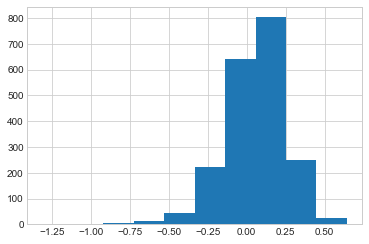

In [54]:
hist(scores);

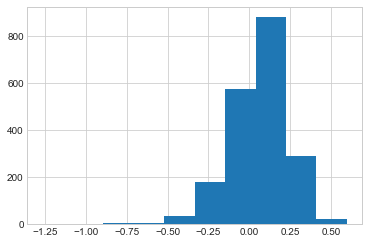

In [55]:
hist(stacking_scores);

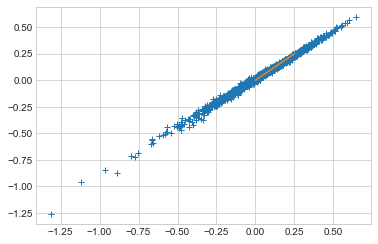

In [63]:
plot(scores, stacking_scores, '+');
plot(np.linspace(0, 0.25, 100), np.linspace(0, 0.25, 100))

In [40]:
stacking_scores

(array([ 0.08893442,  0.06424055,  0.19037547,  0.16908257,  0.01149917,
         0.08923947,  0.18221195,  0.1084338 ,  0.099719  ,  0.20107598,
         0.07944361,  0.0772034 ,  0.08532042,  0.15941857,  0.01965144,
         0.1224592 ,  0.11428732,  0.10029484,  0.16725438,  0.12921632,
         0.11845889,  0.20595628,  0.04685962,  0.18497557,  0.05632858,
         0.1601352 ,  0.19135915,  0.22413949,  0.16165855,  0.09543   ,
         0.11541282,  0.09080735,  0.063166  ,  0.08773563,  0.13248506,
         0.17134733,  0.22296261,  0.17039441,  0.04463414,  0.05756083,
         0.1621376 ,  0.12053197,  0.06487769,  0.16322449,  0.121751  ,
         0.06427964,  0.04436359,  0.19014761,  0.07460497,  0.15883903,
         0.04417429,  0.13700391,  0.15017152, -0.0369886 ,  0.1130116 ,
         0.14934408,  0.18089654,  0.11751153,  0.11570945,  0.12616662,
         0.20809374,  0.03922096,  0.09342908,  0.16778361,  0.18915567,
         0.09281156,  0.14319688,  0.09594235,  0.0

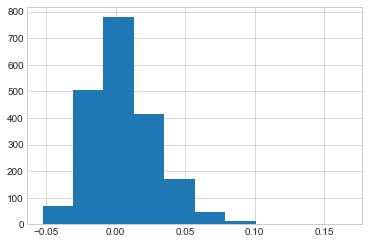

In [56]:
hist(stacking_scores - scores);

In [58]:
np.mean(stacking_scores - scores)

0.0054103687415666384

In [59]:
stacking_scores == scores

array([False, False, False, ..., False, False, False], dtype=bool)

In [60]:
from scipy import stats

In [62]:
stats.mannwhitneyu(stacking_scores, scores, alternative='greater')

MannwhitneyuResult(statistic=2015798.0, pvalue=0.33266058351262134)

In [71]:
stacking_prd.steps[1][1].coef_

user_id_mean     0.870907
user_id_count   -0.000196
dtype: float64

In [72]:
prd

Pipeline(memory=None,
     steps=[('scoresaggregator', ScoresAggregator()), ('linearregression', Adapter[LinearRegression](copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [73]:
prd.steps[1][1]

Adapter[LinearRegression](copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)